In [1]:
cd "/kaggle/input/automated-sleep-staging-beacon-biosignals-2023-2024"

/kaggle/input/automated-sleep-staging-beacon-biosignals-2023-2024


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import spectrogram
from scipy.stats import skew, kurtosis
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os
import random as rd
import pandas as pd
import tensorflow as tf
import time

# full feature display on pandas backend
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Reproductible Results !
import keras
keras.utils.set_random_seed(812)

## Targets: 5 Sleep Stages

In [3]:
hypnograms = pd.read_csv('targets_train.csv')
hypnograms[hypnograms['record'] == 0]

,record,index,identifier,target
0,0,0,0,0
1,0,1,1,0
2,0,2,2,0
3,0,3,3,0
4,0,4,4,0
...,...,...,...,...
1024,0,1023,1023,0
1025,0,1024,1024,0
1026,0,1025,1025,0
1027,0,1026,1026,0


## Pre-Processing: feature extraction from the dataset

Let's define lambda functions for feature extraction

In [4]:
# Assuming your data is stored in a list [array_x, array_y, array_z]
# where each array has shape (1028, 1500)


# Time-domain statistical features
mean_feature = lambda data: np.mean(data, axis=1)
std_feature = lambda data: np.std(data, axis=1)
median_feature = lambda data: np.median(data, axis=1)
kurtosis_feature = lambda data: np.apply_along_axis(lambda x: kurtosis(x), axis=1, arr=data)
skewness_feature = lambda data: np.apply_along_axis(lambda x: skew(x), axis=1, arr=data)
range_feature = lambda data: np.ptp(data, axis=1)
percentile_25_feature = lambda data: np.percentile(data, q=25, axis=1)
percentile_75_feature = lambda data: np.percentile(data, q=75, axis=1)

# Frequency domain features
fft_feature = lambda data: np.abs(np.fft.fft(data)[:, :data.shape[1] // 2])
dominant_frequency_feature = lambda data: np.argmax(fft_feature(data), axis=1)
spectral_entropy_feature = lambda data: np.apply_along_axis(lambda x: -np.sum(x * np.log2(x)), axis=1, arr=fft_feature(data))
bandpower_delta_feature = lambda data: np.sum(fft_feature(data)[:, 0:5], axis=1)
bandpower_theta_feature = lambda data: np.sum(fft_feature(data)[:, 5:8], axis=1)
bandpower_alpha_feature = lambda data: np.sum(fft_feature(data)[:, 8:13], axis=1)
bandpower_beta_feature = lambda data: np.sum(fft_feature(data)[:, 13:30], axis=1)
bandpower_gamma_feature = lambda data: np.sum(fft_feature(data)[:, 30:], axis=1)

# Other features
zero_crossing_rate_feature = lambda data: np.apply_along_axis(lambda x: np.sum(np.diff(np.sign(x)) != 0), axis=1, arr=data)
autocorrelation_feature = lambda data: np.apply_along_axis(lambda x: np.correlate(x, x, mode='full'), axis=1, arr=data).mean(axis=1)

In [5]:
def dfa_(X, Ave=None, L=None):
    X = np.array(X)

    if Ave is None:
        Ave = np.mean(X)

    Y = np.cumsum(X)
    Y -= Ave

    if L is None:
        L = np.floor(len(X) * 1 / (
            2 ** np.array(list(range(4, int(np.log2(len(X))) - 4))))
        )

    F = np.zeros(len(L))  # F(n) of different given box length n

    for i in range(0, len(L)):
        n = int(L[i])                        # for each box length L[i]
        if n == 0:
            print("time series is too short while the box length is too big")
            print("abort")
            exit()
        for j in range(0, len(X), n):  # for each box
            if j + n < len(X):
                c = list(range(j, j + n))
                # coordinates of time in the box
                c = np.vstack([c, np.ones(n)]).T
                # the value of data in the box
                y = Y[j:j + n]
                # add residue in this box
                F[i] += np.linalg.lstsq(c, y)[1]
        F[i] /= ((len(X) / n) * n)
    F = np.sqrt(F)

    Alpha = np.linalg.lstsq(np.vstack(
        [np.log(L), np.ones(len(L))]
    ).T, np.log(F))[0][0]

    return Alpha

dfa = lambda x: np.apply_along_axis(lambda y: dfa_(y), axis=1, arr=x)

In [6]:
# PyEEG
def embed_seq(time_series, tau, embedding_dimension):
    if not type(time_series) == np.ndarray:
        typed_time_series = np.asarray(time_series)
    else:
        typed_time_series = time_series

    shape = (
        typed_time_series.size - tau * (embedding_dimension - 1),
        embedding_dimension
    )

    strides = (typed_time_series.itemsize, tau * typed_time_series.itemsize)

    return np.lib.stride_tricks.as_strided(
        typed_time_series,
        shape=shape,
        strides=strides
    )


def bin_power(X, Band, Fs):
    C = np.fft.fft(X)
    C = abs(C)
    Power = np.zeros(len(Band) - 1)
    for Freq_Index in range(0, len(Band) - 1):
        Freq = float(Band[Freq_Index])
        Next_Freq = float(Band[Freq_Index + 1])
        Power[Freq_Index] = sum(
            C[int(np.floor(Freq / Fs * len(X))): 
                int(np.floor(Next_Freq / Fs * len(X)))]
        )
    Power_Ratio = Power / sum(Power)
    return Power, Power_Ratio


def ap_entropy(X, M=5, R=1):
    N = len(X)

    Em = embed_seq(X, 1, M)
    A = np.tile(Em, (len(Em), 1, 1))
    B = np.transpose(A, [1, 0, 2])
    D = np.abs(A - B)  # D[i,j,k] = |Em[i][k] - Em[j][k]|
    InRange = np.max(D, axis=2) <= R

    # Probability that random M-sequences are in range
    Cm = InRange.mean(axis=0)

    # M+1-sequences in range if M-sequences are in range & last values are close
    Dp = np.abs(
        np.tile(X[M:], (N - M, 1)) - np.tile(X[M:], (N - M, 1)).T
    )

    Cmp = np.logical_and(Dp <= R, InRange[:-1, :-1]).mean(axis=0)

    Phi_m, Phi_mp = np.sum(np.log(Cm)), np.sum(np.log(Cmp))

    Ap_En = (Phi_m - Phi_mp) / (N - M)

    return Ap_En


def permutation_entropy(x, n=5, tau=1):
    PeSeq = []
    Em = embed_seq(x, tau, n)

    for i in range(0, len(Em)):
        r = []
        z = []

        for j in range(0, len(Em[i])):
            z.append(Em[i][j])

        for j in range(0, len(Em[i])):
            z.sort()
            r.append(z.index(Em[i][j]))
            z[z.index(Em[i][j])] = -1

        PeSeq.append(r)

    RankMat = []

    while len(PeSeq) > 0:
        RankMat.append(PeSeq.count(PeSeq[0]))
        x = PeSeq[0]
        for j in range(0, PeSeq.count(PeSeq[0])):
            PeSeq.pop(PeSeq.index(x))

    RankMat = np.array(RankMat)
    RankMat = np.true_divide(RankMat, RankMat.sum())
    EntropyMat = np.multiply(np.log2(RankMat), RankMat)
    PE = -1 * EntropyMat.sum()

    return PE

def spectral_entropy_(X, Band=[0.5,4,7,12,30], Fs=250, Power_Ratio=None):

    if Power_Ratio is None:
        Power, Power_Ratio = bin_power(X, Band, Fs)

    Spectral_Entropy = 0
    for i in range(0, len(Power_Ratio) - 1):
        Spectral_Entropy += Power_Ratio[i] * np.log(Power_Ratio[i])
    Spectral_Entropy /= np.log(
        len(Power_Ratio)
    )  # to save time, minus one is omitted
    return -1 * Spectral_Entropy


def fisher_information_(time_series, embedding_dimension=5, trajectory_length=None):
    """
    Compute Fisher Information from a time series using Singular Spectrum Analysis (SSA).

    Parameters:
    - time_series (numpy.ndarray): 1D array representing the time series.
    - embedding_dimension (int, optional): Embedding dimension for phase space reconstruction. Default is 5.
    - trajectory_length (int, optional): Length of the trajectory in the SSA. Default is the minimum of data length and embedding_dimension.

    Returns:
    - float: Fisher Information.
    """
    if trajectory_length is None:
        trajectory_length = min(len(time_series), embedding_dimension)

    # Phase space reconstruction
    X = np.array([time_series[i:(i+embedding_dimension)] for i in range(len(time_series) - embedding_dimension + 1)])

    # Singular Value Decomposition (SVD)
    _, s, _ = np.linalg.svd(X.T, full_matrices=False)

    # Compute Fisher Information
    fisher_info = np.sum(np.square(np.diff(s[:trajectory_length])) / s[:trajectory_length-1])

    return fisher_info

def svd_entropy(X, Tau=1, DE=5, W=None):
    if W is None:
        Y = embed_seq(X, Tau, DE)
        W = np.linalg.svd(Y, compute_uv=0)
        W /= sum(W)  # normalize singular values

    return -1 * sum(W * np.log(W))

def samp_entropy(X, M=2, R=0.2):

    N = len(X)

    Em = embed_seq(X, 1, M)
    A = np.tile(Em, (len(Em), 1, 1))
    B = np.transpose(A, [1, 0, 2])
    D = np.abs(A - B)  # D[i,j,k] = |Em[i][k] - Em[j][k]|
    InRange = np.max(D, axis=2) <= R
    np.fill_diagonal(InRange, 0)  # Don't count self-matches

    Cm = InRange.sum(axis=0)  # Probability that random M-sequences are in range
    Dp = np.abs(
        np.tile(X[M:], (N - M, 1)) - np.tile(X[M:], (N - M, 1)).T
    )

    Cmp = np.logical_and(Dp <= R, InRange[:-1, :-1]).sum(axis=0)

    # Avoid taking log(0)
    Samp_En = np.log(np.sum(Cm + 1e-100) / np.sum(Cmp + 1e-100))

    return Samp_En


# Nonlinear Dynamics Features:
# Entropy-based features like Approximate Entropy (ApEn) or Sample Entropy.
ap_entropy_feature = lambda x: np.apply_along_axis(lambda y: ap_entropy(y), axis=1, arr=x)
samp_entropy_feature = lambda x: np.apply_along_axis(lambda y: samp_entropy(y), axis=1, arr=x)
permutation_entropy_feature = lambda x: np.apply_along_axis(lambda y: permutation_entropy(y), axis=1, arr=x)
spectral_entropy = lambda x: np.apply_along_axis(lambda y: spectral_entropy_(y), axis=1, arr=x)
svd_entropy_feature = lambda x: np.apply_along_axis(lambda y: svd_entropy(y), axis=1, arr=x)
fisher_information = lambda x: np.apply_along_axis(lambda y: fisher_information_(y), axis=1, arr=x)

In [7]:
# Assuming 'data' is a 2D array with shape (N, 7500) for each EEG channel

# Power Spectral Density (PSD) Features:
# Average power in specific frequency bands (delta, theta, alpha, sigma, beta) using the provided frequency bands.
# Total power across all frequency bands.
total_power = lambda x: np.log(np.sum(np.abs(np.fft.fft(x))**2, axis=1) / x.shape[1])
delta_power = lambda x: np.log(np.sum(np.abs(np.fft.fft(x)[:, 1:5])**2, axis=1) / x.shape[1])
theta_power = lambda x: np.log(np.sum(np.abs(np.fft.fft(x)[:, 5:9])**2, axis=1) / x.shape[1])
alpha_power = lambda x: np.log(np.sum(np.abs(np.fft.fft(x)[:, 9:13])**2, axis=1) / x.shape[1])
sigma_power = lambda x: np.log(np.sum(np.abs(np.fft.fft(x)[:, 13:17])**2, axis=1) / x.shape[1])
beta_power = lambda x: np.log(np.sum(np.abs(np.fft.fft(x)[:, 17:31])**2, axis=1) / x.shape[1])

# Time-Domain Statistical Features:
skewness_feature = lambda data: np.apply_along_axis(lambda x: skew(x), axis=1, arr=data)
kurtosis_feature = lambda x: np.apply_along_axis(lambda y: kurtosis(y), axis=1, arr=x)

# Temporal Dynamics Features:
# Rate of change or slope features to capture temporal dynamics.
slope_feature = lambda x: np.mean(np.abs(np.diff(x, axis=1)), axis=1)

In [8]:
# Wavelet Transform Features:
# Decompose the signal using wavelet transform and extract features from the coefficients.
# Function to apply wavelet transformation to a single epoch
types = ['db4', 'db1', 'sym2', 'coif1', 'bior1.3',
         'haar', 'dmey', 'gaus1', 'cmor', 'morl']

import pywt
def apply_wavelet(epoch, type='db4'): return np.concatenate(pywt.wavedec(
    epoch, type, level=5))  # TODO use db1 instead and add it as another metric ???


def apply_wavelet_to_epoch(data, type='db4'): return np.array(
    [apply_wavelet(epoch, type) for epoch in data])

# Features based on wavelet coefficients


def energy_wavelet(wavelet_data, type):
    wavelet_data = apply_wavelet_to_epoch(wavelet_data, type)
    return np.log(np.sum(
        np.square(wavelet_data), axis=1))


def dominant_frequency_wavelet(
        wavelet_data, type):
    wavelet_data = apply_wavelet_to_epoch(wavelet_data, type)
    return np.argmax(np.abs(wavelet_data), axis=1)


def wavelet_entropy_wavelet(wavelet_data, type):
    wavelet_data = apply_wavelet_to_epoch(wavelet_data, type)
    return np.log(np.abs(np.sum(
        np.square(wavelet_data) * np.log(np.square(wavelet_data)), axis=1)))


def skewness_wavelet(wavelet_data, type):
    wavelet_data = apply_wavelet_to_epoch(wavelet_data, type)
    return np.apply_along_axis(lambda x: np.nan_to_num(
        np.mean((x - np.mean(x))**3) / np.mean((x - np.mean(x))**2)**(3/2)), axis=1, arr=wavelet_data)


def kurtosis_wavelet(wavelet_data, type):
    wavelet_data = apply_wavelet_to_epoch(wavelet_data, type)
    return np.apply_along_axis(lambda x: np.nan_to_num(
        np.mean((x - np.mean(x))**4) / np.mean((x - np.mean(x))**2)**2), axis=1, arr=wavelet_data)

e_p_s_db4 = lambda x: energy_wavelet(x, 'db4')
e_p_s_db1 = lambda x: energy_wavelet(x, 'db1')
e_p_s_sym2 = lambda x: energy_wavelet(x, 'sym2')
e_p_s_coif1 = lambda x: energy_wavelet(x, 'coif1')
e_p_s_bior1_3 = lambda x: energy_wavelet(x, 'bior1.3')
e_p_s_haar = lambda x: energy_wavelet(x, 'haar')
e_p_s_dmey = lambda x: energy_wavelet(x, 'dmey')

d_f_p_s_db4 = lambda x: dominant_frequency_wavelet(x, 'db4')
d_f_p_s_db1 = lambda x: dominant_frequency_wavelet(x, 'db1')
d_f_p_s_sym2 = lambda x: dominant_frequency_wavelet(x, 'sym2')
d_f_p_s_coif1 = lambda x: dominant_frequency_wavelet(x, 'coif1')
d_f_p_s_bior1_3 = lambda x: dominant_frequency_wavelet(x, 'bior1.3')
d_f_p_s_haar = lambda x: dominant_frequency_wavelet(x, 'haar')
d_f_p_s_dmey = lambda x: dominant_frequency_wavelet(x, 'dmey')

w_e_p_s_db4 = lambda x: wavelet_entropy_wavelet(x, 'db4')
w_e_p_s_sym2 = lambda x: wavelet_entropy_wavelet(x, 'sym2')
w_e_p_s_coif1 = lambda x: wavelet_entropy_wavelet(x, 'coif1')
w_e_p_s_dmey = lambda x: wavelet_entropy_wavelet(x, 'dmey')

skewness_p_s_db4 = lambda x: skewness_wavelet(x, 'db4')
skewness_p_s_db1 = lambda x: skewness_wavelet(x, 'db1')
skewness_p_s_sym2 = lambda x: skewness_wavelet(x, 'sym2')
skewness_p_s_coif1 = lambda x: skewness_wavelet(x, 'coif1')
skewness_p_s_bior1_3 = lambda x: skewness_wavelet(x, 'bior1.3')
skewness_p_s_haar = lambda x: skewness_wavelet(x, 'haar')
skewness_p_s_dmey = lambda x: skewness_wavelet(x, 'dmey')

kurtosis_p_s_db4 = lambda x: kurtosis_wavelet(x, 'db4')
kurtosis_p_s_db1 = lambda x: kurtosis_wavelet(x, 'db1')
kurtosis_p_s_sym2 = lambda x: kurtosis_wavelet(x, 'sym2')
kurtosis_p_s_coif1 = lambda x: kurtosis_wavelet(x, 'coif1')
kurtosis_p_s_bior1_3 = lambda x: kurtosis_wavelet(x, 'bior1.3')
kurtosis_p_s_haar = lambda x: kurtosis_wavelet(x, 'haar')
kurtosis_p_s_dmey = lambda x: kurtosis_wavelet(x, 'dmey')

#### 3D Macro features (combine multiple signals together)

In [9]:
def information_based_similarity(data, n=8):
    assert len(data) == 2, 'check that len(data) == 2'
    x = data[0]
    y = data[1]

    Wordlist = []
    Space = [[0, 0], [0, 1], [1, 0], [1, 1]]
    Sample = [0, 1]

    if (n == 1):
        Wordlist = Sample

    if (n == 2):
        Wordlist = Space

    elif (n > 1):
        Wordlist = Space
        Buff = []
        for k in range(0, n - 2):
            Buff = []

            for i in range(0, len(Wordlist)):
                Buff.append(tuple(Wordlist[i]))
            Buff = tuple(Buff)

            Wordlist = []
            for i in range(0, len(Buff)):
                for j in range(0, len(Sample)):
                    Wordlist.append(list(Buff[i]))
                    Wordlist[len(Wordlist) - 1].append(Sample[j])

    Wordlist.sort()

    Input = [[], []]
    Input[0] = x
    Input[1] = y

    SymbolicSeq = [[], []]
    for i in range(0, 2):
        Encoder = np.diff(Input[i])
        for j in range(0, len(Input[i]) - 1):
            if(Encoder[j] > 0):
                SymbolicSeq[i].append(1)
            else:
                SymbolicSeq[i].append(0)

    Wm = []
    Wm.append(embed_seq(SymbolicSeq[0], 1, n).tolist())
    Wm.append(embed_seq(SymbolicSeq[1], 1, n).tolist())

    Count = [[], []]
    for i in range(0, 2):
        for k in range(0, len(Wordlist)):
            Count[i].append(Wm[i].count(Wordlist[k]))

    Prob = [[], []]
    for i in range(0, 2):
        Sigma = 0
        for j in range(0, len(Wordlist)):
            Sigma += Count[i][j]
        for k in range(0, len(Wordlist)):
            Prob[i].append(np.true_divide(Count[i][k], Sigma))

    Entropy = [[], []]
    for i in range(0, 2):
        for k in range(0, len(Wordlist)):
            if (Prob[i][k] == 0):
                Entropy[i].append(0)
            else:
                Entropy[i].append(Prob[i][k] * (np.log2(Prob[i][k])))

    Rank = [[], []]
    Buff = [[], []]
    Buff[0] = tuple(Count[0])
    Buff[1] = tuple(Count[1])
    for i in range(0, 2):
        Count[i].sort()
        Count[i].reverse()
        for k in range(0, len(Wordlist)):
            Rank[i].append(Count[i].index(Buff[i][k]))
            Count[i][Count[i].index(Buff[i][k])] = -1

    IBS = 0
    Z = 0
    n = 0
    for k in range(0, len(Wordlist)):
        if ((Buff[0][k] != 0) & (Buff[1][k] != 0)):
            F = -Entropy[0][k] - Entropy[1][k]
            IBS += np.multiply(np.absolute(Rank[0][k] - Rank[1][k]), F)
            Z += F
        else:
            n += 1

    IBS = np.true_divide(IBS, Z)
    IBS = np.true_divide(IBS, len(Wordlist) - n)

    return IBS

In [10]:
# Define lambda functions for 3D to 1D dimension reduction
# WARNING: every lambda function here should take as input (data) a LIST of 3 np.array of shape (N, 1500) and returns a np.array of shape (N, )

# Euclidean distance between consecutive points
distance_3d = lambda x: np.sqrt(np.sum(np.square(x[0] - x[1]), 1) + np.sum(np.square(x[1] - x[2]), 1) + np.sum(np.square(x[2] - x[0]), 1))
distance_2d = lambda x: np.sqrt(np.sum(np.square(x[0] - x[1]), 1))

# Mean absolute change
mean_absolute_change = lambda data: np.mean(np.abs(np.diff(data, axis=-1)), axis=(0, -1))

# Root mean square change
rms_change = lambda data: np.sqrt(np.mean(np.square(np.diff(data, axis=-1)), axis=(0, -1)))

# Mean resultant length (vector strength)
mean_resultant_length = lambda data: np.sqrt(np.mean(np.square(np.cos(data)), axis=(0, -1)) +
                                             np.mean(np.square(np.sin(data)), axis=(0, -1)))

# Magnitude of the mean vector (sum of cosines and sines)
magnitude_mean_vector = lambda data: np.sqrt(np.mean(np.square(np.mean(np.cos(np.array(data) * (np.pi / 180)), axis=2)), axis=0) +
                                             np.mean(np.square(np.mean(np.sin(np.array(data) * (np.pi / 180)), axis=2)), axis=0))

#### New metrics

Source: https://github.com/forrestbao/pyeeg/

In [11]:
def petrosian_fractal_dimension_(signal):
    """Calculates the Petrosian fractal dimension (PFD) of a signal.

    Args:
    signal: A NumPy array containing the signal.

    Returns:
    The PFD of the signal.
    """

    # Calculate the number of sign changes in the signal derivative.
    derivative = np.diff(signal)
    sign_changes = np.sum(np.sign(derivative[:-1]) != np.sign(derivative[1:]))

    # Calculate the PFD of the signal.
    pfd = np.log10(len(signal)) / np.log10(len(signal) + sign_changes)

    return pfd


def hurst_exponent_(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series
    
    Source: https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e
    """
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

petrosian_fractal_dimension = lambda X: np.array([petrosian_fractal_dimension_(x) for x in X])
hurst_exponent = lambda X: np.array([hurst_exponent_(x) for x in X])

In [12]:
def LLE(x, tau=2, n=4, T=1, fs=250):
    Em = embed_seq(x, tau, n)
    M = len(Em)
    A = np.tile(Em, (len(Em), 1, 1))
    B = np.transpose(A, [1, 0, 2])

    #  square_dists[i,j,k] = (Em[i][k]-Em[j][k])^2
    square_dists = (A - B) ** 2

    #  D[i,j] = ||Em[i]-Em[j]||_2
    D = np.sqrt(square_dists[:, :, :].sum(axis=2))

    # Exclude elements within T of the diagonal
    band = np.tri(D.shape[0], k=T) - np.tri(D.shape[0], k=-T - 1)
    band[band == 1] = np.inf

    # nearest neighbors more than T steps away
    neighbors = (D + band).argmin(axis=0)

    # in_bounds[i,j] = (i+j <= M-1 and i+neighbors[j] <= M-1)
    inc = np.tile(np.arange(M), (M, 1))
    row_inds = (np.tile(np.arange(M), (M, 1)).T + inc)
    col_inds = (np.tile(neighbors, (M, 1)) + inc.T)
    in_bounds = np.logical_and(row_inds <= M - 1, col_inds <= M - 1)

    # Uncomment for old (miscounted) version
    # in_bounds = numpy.logical_and(row_inds < M - 1, col_inds < M - 1)
    row_inds[~in_bounds] = 0
    col_inds[~in_bounds] = 0

    # neighbor_dists[i,j] = ||Em[i+j]-Em[i+neighbors[j]]||_2
    neighbor_dists = np.ma.MaskedArray(D[row_inds, col_inds], ~in_bounds)

    #  number of in-bounds indices by row
    J = (~neighbor_dists.mask).sum(axis=1)

    # Set invalid (zero) values to 1; log(1) = 0 so sum is unchanged
    neighbor_dists[neighbor_dists == 0] = 1
    d_ij = np.sum(np.log(neighbor_dists.data + 1e-100), axis=1)
    mean_d = d_ij[J > 0] / J[J > 0]

    x = np.arange(len(mean_d))
    X = np.vstack((x, np.ones(len(mean_d)))).T
    [m, c] = np.linalg.lstsq(X, mean_d)[0]
    Lexp = fs * m
    return Lexp

# lyapunov_exponent_ = lambda x: np.mean(np.log(np.abs(np.diff(x) + 1e-10)))
# lyapunov_exponent = lambda X: np.array([lyapunov_exponent_(x) for x in X])
lyapunov_exponent = lambda X: np.array([LLE(x) for x in X]) # TODO REWORK IT

In [13]:
import numpy as np


def calc_L(X, k, m):
    """
    Return Lm(k) as the length of the curve.

    """
    N = X.size

    n = np.floor((N-m)/k).astype(np.int64)
    norm = (N-1) / (n*k)

    sum = np.sum(np.abs(np.diff(X[m::k], n=1)))

    Lm = (sum*norm) / k

    return Lm


def calc_L_average(X, k):
    """
    Return <L(k)> as the average value over k sets of Lm(k).

    """
    calc_L_series = np.frompyfunc(lambda m: calc_L(X, k, m), 1, 1)

    L_average = np.average(calc_L_series(np.arange(1, k+1)))

    return L_average


def higuchi_fractal_dimension_(X, k_max=5):
    """
    Source: https://github.com/hiroki-kojima/HFDA
    Measure the fractal dimension of the set of points (t, f(t)) forming
    the graph of a function f defined on the unit interval.

    Parameters
    ----------
    X : ndarray
        time series.

    k_max : int
        Maximum interval time that a new series.

    Returns
    -------
    D : float
        Fractal dimension.

    Examples
    --------
    >>> N = np.power(2, 15)
    >>> X = np.sin(np.linspace(0, 1000, N))
    >>> j = 11
    >>> k_max = np.floor(np.power(2, (j-1)/4)).astype(np.int64)
    >>> D = hfda.measure(X, k_max)
    >>> D
    1.0005565919808783

    """
    calc_L_average_series = np.frompyfunc(lambda k: calc_L_average(X, k), 1, 1)

    k = np.arange(1, k_max+1)
    L = calc_L_average_series(k).astype(np.float64)

    D, _ = - np.polyfit(np.log2(k), np.log2(L), 1)

    return D

higuchi_fractal_dimension = lambda X: np.array([higuchi_fractal_dimension_(x) for x in X])

In [14]:
def hjorth_activity_(signal):
    """
    Compute Hjorth activity parameter for a given signal.
    https://en.wikipedia.org/wiki/Hjorth_parameters

    Parameters:
    - signal: 1D numpy array representing the EEG signal.

    Returns:
    - activity: Hjorth activity parameter.
    """
    return np.var(signal)

def hjorth_mobility_(signal):
    """
    Compute Hjorth mobility parameter for a given signal.
    https://en.wikipedia.org/wiki/Hjorth_parameters

    Parameters:
    - signal: 1D numpy array representing the EEG signal.

    Returns:
    - mobility: Hjorth mobility parameter.
    """
    diff_1 = np.diff(signal)
    variance = np.var(signal)
    var_diff_1 = np.var(diff_1)
    return np.sqrt(var_diff_1 / variance)

def hjorth_complexity_(signal):
    """
    Compute Hjorth complexity parameter for a given signal.
    https://en.wikipedia.org/wiki/Hjorth_parameters

    Parameters:
    - signal: 1D numpy array representing the EEG signal.

    Returns:
    - complexity: Hjorth complexity parameter.
    """
    diff_1 = np.diff(signal)
    diff_2 = np.diff(diff_1)
    var_diff_1 = np.var(diff_1)
    var_diff_2 = np.var(diff_2)
    mobility = hjorth_mobility_(signal)
    return np.sqrt(var_diff_2 / var_diff_1) / mobility

hjorth_activity = lambda X: np.array([hjorth_activity_(x) for x in X])
hjorth_mobility = lambda X: np.array([hjorth_mobility_(x) for x in X])
hjorth_complexity = lambda X: np.array([hjorth_complexity_(x) for x in X])

### Litterature based features:
- https://centralesupelec.edunao.com/pluginfile.php/326038/course/section/50102/entropy-18-00272.pdf

In [15]:
pip install pyhht

Note: you may need to restart the kernel to use updated packages.


In [16]:
from pyhht import EMD
from scipy.signal import find_peaks

def emd_gzc_features_(signal_, sampling_rate=250):

    # Empirical Mode Decomposition (EMD)
    decomposer = EMD(signal_)
    imfs = decomposer.decompose()

    # Generalized Zero Crossing (GZC) method on Intrinsic Mode Functions (IMF)
    gzc_features = []
    for imf in imfs:
        # Count zero crossings using scipy's find_peaks
        peaks, _ = find_peaks(imf)
        zero_crossings = len(peaks)

        # Append the zero crossings count as a feature
        gzc_features.append(zero_crossings)

    return gzc_features

emd_gzc_features = lambda X: np.array([emd_gzc_features_(x) for x in X])

In [17]:
import numpy as np
from scipy import signal

def mmd_feature_(signal_, window_length=750):
    num_samples = len(signal_)
    num_windows = num_samples // window_length
    mmd_values = []

    for i in range(num_windows):
        start_index = i * window_length
        end_index = (i + 1) * window_length

        # Extract sub-window
        sub_window = signal_[start_index:end_index]

        # Calculate MMD for the sub-window
        max_val = np.max(sub_window)
        min_val = np.min(sub_window)
        distance = np.sqrt((max_val - min_val)**2)

        mmd_values.append(distance)

    # Sum of MMD values for all sub-windows
    mmd_sum = np.sum(mmd_values)

    return mmd_sum


def esis_feature_(signal_, fs=250):
    f, Pxx = signal.welch(signal_, fs, nperseg=len(signal_))
    pass_frequency = f[np.argmax(Pxx)]

    # Calculate wavelength based on the provided assumption
    num_samples = len(signal_)
    if num_samples < 10000:
        wavelength = 100
    else:
        wavelength = 10**(np.floor(np.log10(num_samples)) - 1)
    # Calculate velocity
    velocity = pass_frequency * wavelength

    # Calculate Esis
    esis_values = np.square(np.abs(signal_)) * velocity
    esis_sum = np.sum(esis_values)

    return esis_sum 
mmd_feature = lambda X: np.array([np.log(mmd_feature_(x)) for x in X])
esis_feature = lambda X: np.array([np.log(esis_feature_(x)) for x in X])

In [18]:
import matplotlib.pyplot as plt
def generate_timeseries():
    length = 7500
    frequency_1 = 5*np.random.rand()  # Frequency of the sinusoidal signal
    frequency_2 = 5*np.random.rand()  # Frequency of the sinusoidal signal
    amplitude_1 = np.random.rand()
    amplitude_2 = np.random.rand()
    noise_level = 0.2  # Adjust the noise level as needed

    # Generate sinusoidal signal
    time = np.arange(length)
    sinusoidal_signal_1 = amplitude_1 * np.sin(2 * np.pi * frequency_1 * time / length)
    sinusoidal_signal_2 = amplitude_2 * np.sin(2 * np.pi * frequency_2 * time / length)

    # Add noise to the signal
    your_time_series = sinusoidal_signal_1 + sinusoidal_signal_2 + noise_level * np.random.normal(size=length)
    return your_time_series


def plot_mmd(signal_, window_length=750):
    num_samples = len(signal_)
    num_windows = num_samples // window_length
    mmd_values = []

    for i in range(num_windows):
        start_index = i * window_length
        end_index = (i + 1) * window_length

        # Extract sub-window
        sub_window = signal_[start_index:end_index]

        # Calculate MMD for the sub-window
        max_val = np.max(sub_window)
        min_val = np.min(sub_window)
        distance = np.sqrt((max_val - min_val)**2)

        mmd_values.append(distance)
    figure = plt.figure()
    plt.plot(mmd_values, label='MMD values in each sub-window')
    plt.xlabel('Sub-window index')
    plt.ylabel('MMD value')
    plt.title('Maximum-Minimum Distance (MMD) Feature')
    plt.legend()
    plt.show()

def plot_esis(signal_, fs=250):
    f, Pxx = signal.welch(signal_, fs, nperseg=len(signal_))
    plt.plot(f, Pxx)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency Density')
    plt.title('Frequency Power Spectrum')
    plt.show()
    
# your_time_series = generate_timeseries()
# plt.plot(your_time_series)
# # Example usage:
# # Assuming 'your_time_series' is your EEG signal (numpy array) sampled at 250Hz for 30 seconds

# # Plot MMD values
# plot_mmd(your_time_series)
# # Plot Frequency Power Spectrum for Esis
# plot_esis(your_time_series)

# mmd_result = mmd_feature_(your_time_series)
# esis_result = esis_feature_(your_time_series)

# print("MMD Feature:", mmd_result)
# print("Esis Feature:", esis_result)

### Exotic New Features (To be Implemented / Work in Progress):
- trend-residual decomposition de la norm_acc (3D Macro feature) puis calcul de metriques classiques (mean/std/skew/kurtosis, i.e. 4 premiers moments + min/max)
    - on décompose en 1) la trend (-> 4 premiers moments + min/max) et 2) residual (-> 4 premiers moments + min/max)
- on fait de même sur chaque signal EEG : coef d'un fit trend-residual AR:
    - on décompose en 1) la trend (-> 4 premiers moments + min/max) et 2) residual (-> 4 premiers moments + min/max)

In [19]:
mean_sign_ = lambda signal: np.sign(np.mean(signal))
mean_sign = lambda X: np.array([mean_sign_(x) for x in X])

In [20]:
import statsmodels.api as sm
def ar_coefficients_(time_series, order_of_ar_model=1): # TODO : A OPTIMISER CAR BEAUCOUP BEAUCOUP TROP LENT....
    # warning, time_series must be 1D

    # Fit AR model
    ar_model = sm.tsa.ARIMA(time_series, order=(order_of_ar_model, 0, 0))  # AR order (p), difference order (d), moving average order (q)
    ar_results = ar_model.fit(low_memory=True)
    
    # Get AR coefficients
    ar_coefficients = ar_results.params[0]
    
    return ar_coefficients

ar_coefficients = lambda X: np.array([ar_coefficients_(x) for x in X])

In [21]:
import numpy as np
from scipy.signal import welch
from scipy.spatial.distance import cdist

def compute_itakura_distance(data, fs=250, nperseg=250, noverlap=None):
    """
    Compute the Itakura distance between two EEG signals using power spectral densities.

    Parameters:
    - data (list of numpy.ndarray): List containing two EEG signals.
    - fs (float, optional): Sampling frequency of the EEG signals. Default is 250 Hz.
    - nperseg (int, optional): Number of data points used in each block for the Welch method. Default is 250.
    - noverlap (int, optional): Number of points to overlap between segments for the Welch method. Default is None.

    Returns:
    - numpy.ndarray: Itakura distance array.
    """
    itakura_distances = []

    eeg_signal1 = data[0]  # (1028, 7500) 2D array
    eeg_signal2 = data[1]  # (1028, 7500) 2D array

    for i in range(eeg_signal1.shape[0]):
        # Extract individual signals
        signal1 = eeg_signal1[i, :]
        signal2 = eeg_signal2[i, :]

        # Compute power spectral densities using Welch method
        _, psd1 = welch(signal1, fs=fs, nperseg=nperseg, noverlap=noverlap)
        _, psd2 = welch(signal2, fs=fs, nperseg=nperseg, noverlap=noverlap)

        # Use the Itakura distance on the logarithm of the power spectral densities
        log_psd1 = np.log(psd1)
        log_psd2 = np.log(psd2)

        # Reshape to 2D array
        log_psd1_2d = log_psd1.reshape(1, -1)
        log_psd2_2d = log_psd2.reshape(1, -1)

        # Compute Itakura distance
        itakura_dist = cdist(log_psd1_2d, log_psd2_2d)  # 'kl' is Kullback-Leibler divergence
        itakura_distances.append(itakura_dist[0, 0])

    return np.array(itakura_distances)

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np
# # Replace 'your_time_series' with your actual time series data
# # For example, you can load your data from a file or use a generated time series.
# # Ensure that your time series is a 1D NumPy array.
# fig = plt.figure()
# your_time_series = generate_timeseries()
# plt.plot(your_time_series)

# # ATTENTION: fonction_ désigne la fonction qui prend la timeseries en array 1D (7500 de longueur) en entrée et renvoie 1 scalaire
# # VS fonction (sans "_" à a fin) qui prend le 2D array (N, 7500) et renvoie un array (N, 1)
# # TODO: regarder si vectorisation possible ? (je pense pas)

# # Compute the Lyapunov exponent
# print("Lyapunov Exponent simple :", LLE(your_time_series))

# pfd_ = petrosian_fractal_dimension_(your_time_series)
# print("Petrosian Fractal Dimension:", pfd_)

# hurst_ = hurst_exponent_(your_time_series)
# print("Hurst Coefficient:", hurst_)
# hfd_ = higuchi_fractal_dimension_(your_time_series)
# print("Higuchi Fractal Dimension 2:", hfd_)

# # Compute Hjorth parameters
# activity_value = hjorth_activity_(your_time_series)
# mobility_value = hjorth_mobility_(your_time_series)
# complexity_value = hjorth_complexity_(your_time_series)

# print("Hjorth Activity:", activity_value)
# print("Hjorth Mobility:", mobility_value)
# print("Hjorth Complexity:", complexity_value)

# gzc_features = emd_gzc_features_(your_time_series)
# print("Generalized Zero Crossing", gzc_features)

## Creating a (declarative) pipeline for feature extraction

In [23]:
frequency_bands = {
    "low_freq": [0.01, 0.5],
    "medium_delta": [0.5, 2],
    "delta": [0.5, 4],
    "theta": [4, 8],
    "medium_theta": [2, 6],
    "medium_alpha": [6, 8],
    "alpha": [8, 12],
    "sigma": [12, 16],
    "beta": [16, 30]
}

statistics_eeg = {
    # Classical statistics
    "stdev": lambda x: np.std(x, 1),
    "mean": lambda x: np.mean(np.abs(x), 1),
    "skewness": skewness_feature,
    "kurtosis": kurtosis_feature,
    "median": median_feature,
    "mean_sign": mean_sign,
    "percentile_25": percentile_25_feature,
    "percentile_75": percentile_75_feature,
    "slope": slope_feature,
#     "range": range_feature, # Explose trop...

    # Entropy-based features
    "detrended_fluctuation_analysis": dfa,
#     "ap_entropy": ap_entropy_feature, # TOO LONG (got it with torcheeg)
#     "permutation_entropy": permutation_entropy_feature, # TOO LONG
    "spectral_entropy": spectral_entropy,
    "svd_entropy": svd_entropy_feature,
    "fisher_information": fisher_information,
#     "samp_entropy": samp_entropy_feature, # TOO LONG

    # Fractal dimensions
    "petrosian_fractal_dimension": petrosian_fractal_dimension,
    "hurst_exponent": hurst_exponent,
#     "lyapunov_exponent": lyapunov_exponent, # TOO LONG !!!!! (à optimiser)
    "higuchi_fractal_dimension": higuchi_fractal_dimension,
    "hjorth_activity": hjorth_activity,
    "hjorth_mobility": hjorth_mobility,
    "hjorth_complexity": hjorth_complexity,
#     "emd_gzc": emd_gzc_features, # Watch out multiple output??? A REPRENDRE !!! 
    "mmd": mmd_feature,
#     "esis":  esis_feature, # TODO : PRODUIT DE L'INFINI !!!! A CHECKER AVEC PyEEG (explose trop...)

    # Wavelet features
    "energy_wavelet_db4": e_p_s_db4,
    "energy_wavelet_db1": e_p_s_db1,
    "energy_wavelet_sym2": e_p_s_sym2,
    "energy_wavelet_coif1": e_p_s_coif1,
    "energy_wavelet_bior1_3": e_p_s_bior1_3,
    "energy_wavelet_haar": e_p_s_haar,
    "energy_wavelet_dmey": e_p_s_dmey,
    "dominant_frequency_wavelet_db4": d_f_p_s_db4,
    "dominant_frequency_wavelet_db1": d_f_p_s_db1,
    "dominant_frequency_wavelet_sym2": d_f_p_s_sym2,
    "dominant_frequency_wavelet_coif1": d_f_p_s_coif1,
    "dominant_frequency_wavelet_bior1_3": d_f_p_s_bior1_3,
    "dominant_frequency_wavelet_haar": d_f_p_s_haar,
    "dominant_frequency_wavelet_dmey": d_f_p_s_dmey,
    "wavelet_entropy_wavelet_db4": w_e_p_s_db4,
    "wavelet_entropy_wavelet_sym2": w_e_p_s_sym2,
    "wavelet_entropy_wavelet_coif1": w_e_p_s_coif1,
    "wavelet_entropy_wavelet_dmey": w_e_p_s_dmey,
    "skewness_wavelet_db4": skewness_p_s_db4,
    "skewness_wavelet_db1": skewness_p_s_db1,
    "skewness_wavelet_sym2": skewness_p_s_sym2,
    "skewness_wavelet_coif1": skewness_p_s_coif1,
    "skewness_wavelet_bior1_3": skewness_p_s_bior1_3,
    "skewness_wavelet_haar": skewness_p_s_haar,
    "skewness_wavelet_dmey": skewness_p_s_dmey,
    "kurtosis_wavelet_db4": kurtosis_p_s_db4,
    "kurtosis_wavelet_db1": kurtosis_p_s_db1,
    "kurtosis_wavelet_sym2": kurtosis_p_s_sym2,
    "kurtosis_wavelet_coif1": kurtosis_p_s_coif1,
    "kurtosis_wavelet_bior1_3": kurtosis_p_s_bior1_3,
    "kurtosis_wavelet_haar": kurtosis_p_s_haar,
    "kurtosis_wavelet_dmey": kurtosis_p_s_dmey,

    # Frequency Domain Features (PSD)
    "total_power_fft": total_power,
    "dominant_frequency_fft": dominant_frequency_feature,
    "spectral_entropy_fft": spectral_entropy_feature,
    "bandpower_delta_fft": bandpower_delta_feature,
    "bandpower_theta_fft": bandpower_theta_feature,
    "bandpower_alpha_fft": bandpower_alpha_feature,
    "bandpower_beta_fft": bandpower_beta_feature,
    "bandpower_gamma_fft": bandpower_gamma_feature,
    
    # AR Coefficient
#     "ar_coefficients": ar_coefficients (torch eeg got it)

}

statistics_acc = {
    # Classical Statistics
    "std_feature": std_feature,
    "mean_feature": mean_feature,
    "median_feature": median_feature,
    "mean_sign_feature": mean_sign,
    "skewness_feature": skewness_feature,
    "kurtosis_feature": kurtosis_feature,
    "percentile_25_feature": percentile_25_feature,
    "percentile_75_feature": percentile_75_feature,
    "range_feature": range_feature,

    # Fractal dimensions
    "hurst_exponent_feature": hurst_exponent,

    # Entropy-based features
    "dominant_frequency_feature": dominant_frequency_feature,
    "spectral_entropy_feature": spectral_entropy_feature,
#     "ap_entropy_feature": ap_entropy_feature, # TOO LONG
#     "samp_entropy_feature": samp_entropy_feature, # TOO LONG
#     "permutation_entropy_feature": permutation_entropy_feature, # TOO LONG
    "svd_entropy_feature": svd_entropy_feature,
    "fisher_information_feature": fisher_information,
    
    # AR Coefficient
#     "ar_coefficients_feature": ar_coefficients, # TOO LONG

}

macro_features = {
    "distance_3d":
        {
            "type": "Accelerometer",
            "channels": [0, 1, 2],
            "function": distance_3d,
        },
    "mean_absolute_change":
        {
            "type": "Accelerometer",
            "channels": [0, 1, 2],
            "function": mean_absolute_change,
        },
    "rms_change":
        {
            "type": "Accelerometer",
            "channels": [0, 1, 2],
            "function": rms_change,
        },
}

# Add EEG pair-wise similarity features for all pairs
for i in range(5):
    for j in range(i + 1, 5):
#         feature_name = f"eeg_information_based_similarity_{i+1}_{j+1}" # TODO A REPRENDRE CAR NE MARCHE PAS DU TOUT ......... (Entropy[j] > 0. use a.all() bool error numpy ...)
#         macro_features[feature_name] = {
#             "type": "EEG",
#             "channels": [i, j],
#             "function": information_based_similarity,
#         }
        feature_name = f"eeg_itakura_distance_{i+1}_{j+1}"
        macro_features[feature_name] = {
            "type": "EEG",
            "channels": [i, j],
            "function": compute_itakura_distance,
        }
    
# TODO (pas tout de suite dans le projet...): REFACTORING de macro_features first concatenate the data list into a 3D array of size (3, N, 1500) and then do lambda -> (N, ) !!!!
# Warning: f must be a function that takes a list as input and returns a scalar !!! [N to 1]
# TODO 2: possibilité de calculer des macro_features non pas sur la data de base mais sur des features déjà calculées -> goal : vectorisation / multi-processing ?

def get_relative_spectral_power_for_epoch(data,typ, frequency_bands):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    if typ == "EEG":
        FS = 250  # EEG sampling frequency
    elif typ == "Accelerometer":
        FS = 50  # Accelerometer sampling frequency
    else:
        raise ValueError("check typ")
    psds = []
    sfreqs, t, psd = spectrogram(data, FS, nperseg=1000)
    
    psd = np.mean(np.abs(psd), -1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:, (sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)

        # rescaling fix for Acc data
        if typ == "EEG":
            spectral_power_band[name+'_eeg'] = spec_power / np.sum(psd, 1)
        elif typ == "Accelerometer":
            # Taking the log transformation ...
            spectral_power_band[name+'_acc'] = np.log(spec_power / np.sum(psd, 1))

    return spectral_power_band

def clip_data(data, typ):
    if typ == "EEG":
        data_clip_limit = 200  # Clipping limit for EEG data
    elif typ == "Accelerometer":
        data_clip_limit = 1.5
    else:
        raise ValueError("check typ")
    sliced_data = np.clip(data, -data_clip_limit, data_clip_limit)
    return sliced_data

def compute_stats(data, statistics, verbose=True):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {}
    for k, f in statistics.items():
        if verbose:
            try:
                print(f"Computing {k}")
                result[k] = f(data)
            except Exception as e:
                print(f"Error [[{e}]] - for stat {k}")
                print(f"Input Data: {data}")
                raise e
        else:
            result[k] = f(data)
    return result

#### Visualizing the data: about the importance of clipping the signals and removing Extreme Values in some cases

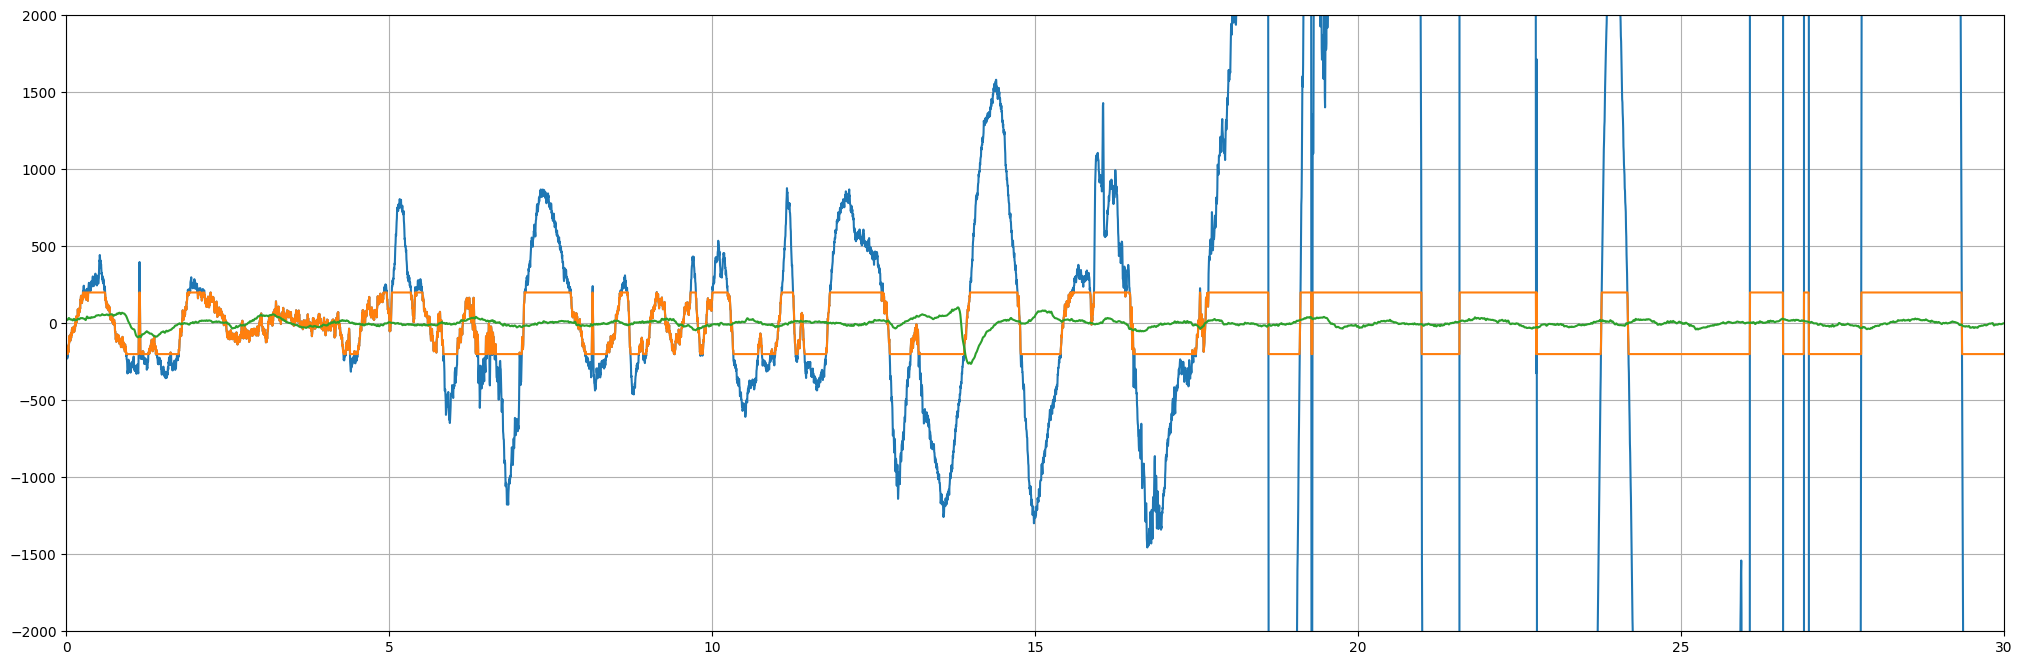

In [24]:
def plot_eeg_epoch(eeg,epoch_index):
    plt.plot(np.arange(0,250 * 30) / 250, eeg[250 * epoch_index * 30:250 * (epoch_index + 1) * 30])
    plt.ylim([-2000, 2000])
    plt.xlim(0,30)

# let's load the first record
eeg = np.load('sample/sample/f7_O2.npy')
eeg_clipped = clip_data(np.load('sample/sample/f7_O2.npy'), "EEG")
eeg_frontal = np.load('sample/sample/f8_f7.npy')
# plot it !
plt.figure(figsize=(25, 8))
plot_eeg_epoch(eeg,730)
plot_eeg_epoch(eeg_clipped,730)
plot_eeg_epoch(eeg_frontal, 20)
plt.grid()

In [25]:
epoch_index = 730
eeg_signal = eeg[250 * epoch_index * 30:250 * (epoch_index + 1) * 30]
eeg_signal_2d = np.reshape(eeg_signal, (1, -1))
eeg_signal_2d.shape
eeg_signal_clipped = np.clip(eeg[250 * epoch_index * 30:250 * (epoch_index + 1) * 30], -200, 200)
eeg_signal_clipped_2d = np.reshape(eeg_signal_clipped, (1, -1))

### PyTorch EEG Features: TorchEEG library

See https://torcheeg.readthedocs.io/en/latest/torcheeg.transforms.html for reference

In [26]:
pip install torcheeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 14.4 MB/s eta 0:00:00
  Obtaining dependency information for einops>=0.4.1 from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for mne_connectivity>=0.4.0 from https://files.pythonhosted.org/packages/5f/9c/b22094268040108fe3e6a6555831a61fe00a75d2c968958ca2afaa858ef7/mne_connectivity-0.6.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
from torcheeg import transforms

In [28]:
transforms.BandBinPower()(eeg=eeg_signal_2d, sampling_rate=250)['eeg'] # attention ça renvoie 1 scalaire...

array([[0.54595811, 0.25758062, 0.15820355, 0.03825772]])

In [29]:
# band_dict = {'alpha': [8, 14], 'beta': [14, 31], 'gamma': [31, 49], 'theta': [4, 8]}
transforms.BandSpectralEntropy()(eeg=eeg_signal_2d, sampling_rate=250)['eeg'] # attention ça renvoie 1 scalaire...

array([[0.7008009]])

In [30]:
transforms.PearsonCorrelation()(eeg=np.array([eeg_signal_clipped_2d, eeg_signal_2d]), sampling_rate=250)['eeg'] # à faire comme distance_2d (multiple channels)

array([[[1.]],

       [[1.]]])

In [31]:
transforms.PhaseLockingCorrelation()(eeg=np.array([eeg_signal_clipped_2d, eeg_signal_2d]), sampling_rate=250)['eeg'] # à faire comme distance_2d (multiple channels)

array([[[0.]],

       [[0.]]])

In [32]:
def reshape_eeg(eeg, clip=True):
    if clip:
        eeg = np.clip(eeg, -200, 200)
    return np.reshape(eeg, (1, -1))

banddiffereentialentropy = lambda X: np.array([transforms.BandDifferentialEntropy()(eeg=reshape_eeg(x, clip=True), sampling_rate=250)['eeg'][0] for x in X])
bandpowerspectraldensity = lambda X: np.array([transforms.BandPowerSpectralDensity()(eeg=reshape_eeg(x, clip=True), sampling_rate=250)['eeg'][0] for x in X])
bandmeanabsolutedeviation = lambda X: np.array([transforms.BandMeanAbsoluteDeviation()(eeg=reshape_eeg(x, clip=True), sampling_rate=250)['eeg'][0] for x in X])
bandkurtosis = lambda X: np.array([transforms.BandKurtosis()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
bandskewness = lambda X: np.array([transforms.BandSkewness()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
bandapproximateentropy = lambda X: np.array([transforms.BandApproximateEntropy()(eeg=reshape_eeg(x, clip=True), sampling_rate=250)['eeg'][0] for x in X])
bandsampentropy = lambda X: np.array([transforms.BandSampleEntropy()(eeg=reshape_eeg(x, clip=True), sampling_rate=250)['eeg'][0] for x in X])
bandsvdentropy = lambda X: np.array([transforms.BandSVDEntropy()(eeg=reshape_eeg(x, clip=True), sampling_rate=250)['eeg'][0] for x in X])
banddetrendedfluctuationanalysis = lambda X: np.array([transforms.BandDetrendedFluctuationAnalysis()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
bandpetrosianfractaldimension = lambda X: np.array([transforms.BandPetrosianFractalDimension()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
bandhiguchifractaldimension = lambda X: np.array([transforms.BandHiguchiFractalDimension()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
bandhjorthmobility = lambda X: np.array([transforms.BandHjorth()(eeg=reshape_eeg(x, clip=False), sampling_rate=250, mode='mobility')['eeg'][0] for x in X])
bandhjorthcomplexity = lambda X: np.array([transforms.BandHjorth()(eeg=reshape_eeg(x, clip=False), sampling_rate=250, mode='complexity')['eeg'][0] for x in X])
bandhurst = lambda X: np.array([transforms.BandHurst()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
bandbinpower = lambda X: np.array([transforms.BandBinPower()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])
arcoefficient = lambda X: np.array([transforms.ARRCoefficient()(eeg=reshape_eeg(x, clip=False), sampling_rate=250, order=3)['eeg'][0] for x in X])
bandspectralentropy = lambda X: np.array([transforms.BandSpectralEntropy()(eeg=reshape_eeg(x, clip=False), sampling_rate=250)['eeg'][0] for x in X])


statistics_eeg_torcheeg = {
    "bandbinpower": bandbinpower,
    "banddiffereentialentropy": banddiffereentialentropy,
    "bandspectralentropy": bandspectralentropy,
    "bandpowerspectraldensity": bandpowerspectraldensity,
    "bandmeanabsolutedeviation": bandmeanabsolutedeviation,
    "bandkurtosis": bandkurtosis,
    "bandskewness": bandskewness,
#     "bandapproximateentropy": bandapproximateentropy, # TOO LONG
#     "bandsampentropy": bandsampentropy, # TOO LONG
    "bandsvdentropy": bandsvdentropy, 
    "banddetrendedfluctuationanalysis": banddetrendedfluctuationanalysis,
    "bandpetrosianfractaldimension": bandpetrosianfractaldimension,
    "bandhiguchifractaldimension": bandhiguchifractaldimension,
    "bandhjorthmobility": bandhjorthmobility,
    "bandhjorthcomplexity": bandhjorthcomplexity,
#     "bandhurst": bandhurst,
    "arcoefficient": arcoefficient,
    "bandspectralentropy": bandspectralentropy,
}


def compute_stats_torcheeg(data, statistics, verbose=True):
    """
    Compute the statistics of a signal either per subband (len > 1) or globally (len = 1)
    """
    result = {}
    subbands = ['alpha', 'beta', 'gamma', 'theta']
    for k, f in statistics.items():
        if verbose:
            try:
                print(f"Computing {k}")
                res_ = f(data)
                n_subbands = res_.shape[1]
                if n_subbands == 1: 
                    # just store the scalar feature
                    result[k] = res_.flatten()
                else:
                    assert n_subbands == len(subbands), "revoir l'implémentation de la feature"
                    # store each subbands result
                    for i in range(n_subbands):
                        result[f"{k}_{subbands[i]}"] = res_[:, i]              
            except Exception as e:
                print(f"Error [[{e}]] - for stat {k}")
                print(f"Input Data: {data}")
                raise e
        else:
            result[k] = f(data)
    return result

## Pre-processing step (warning: takes a lot of time; refer to caching below)

TODO: Multiprocessing

In [33]:
data = {}
hypnograms = {}

In [34]:
def preprocess_data(data_for_records, hypnogram_for_records, training_records_path, targets_csv_path, statistics_eeg, statistics_acc, macro_features, verbose=True):

    # Load the hypnograms (targets)
    hypnograms = pd.read_csv(targets_csv_path)

    # Loop through each record in the training records directory
    for record in os.listdir(training_records_path):
        print(record)
        record_number = int(record[-5])  # Extract record number from file name
        x = np.load(os.path.join(training_records_path, record))

        # Initialize the dictionary for this record
        if record not in data_for_records.keys():
            data_for_records[record] = {}

        # Extracting and processing EEG channels
        for i in range(5):  # 5 EEG channels
            channel_name = f"EEG_{i + 1}"  # EEG_1, EEG_2, ...
            eeg_data = x[:, 1 + i * 7500: 1 + (i + 1) * 7500]
            eeg_data_clipped = clip_data(eeg_data, "EEG")
            data_for_records[record][channel_name] = get_relative_spectral_power_for_epoch(eeg_data_clipped, "EEG", frequency_bands)
            data_for_records[record][channel_name].update(compute_stats_torcheeg(eeg_data, statistics_eeg_torcheeg, verbose=verbose)) # no clip
            data_for_records[record][channel_name].update(compute_stats(eeg_data_clipped, statistics_eeg, verbose=verbose))

        # Extracting and processing accelerometer channels
        for i in range(3):  # 3 Accelerometer channels
            channel_name = f"Accelerometer_{i + 1}"  # Accelerometer_1, ...
            acc_data = x[:, 37501 + i * 1500: 37501 + (i + 1) * 1500]
            acc_data_clipped = clip_data(acc_data, "Accelerometer")
            data_for_records[record][channel_name] = get_relative_spectral_power_for_epoch(acc_data_clipped, "Accelerometer", frequency_bands)
            data_for_records[record][channel_name].update(compute_stats(acc_data_clipped, statistics_acc, verbose=verbose))

        # Compute macro features
        for macro_feature_name, macro_feature in macro_features.items():
            if verbose:
                print(f"Computing {macro_feature_name}")
            data = []
            if macro_feature['type'] == 'EEG':
                for channel in macro_feature['channels']:
                    signal_ = clip_data(x[:, 1 + channel * 7500: 1 + (channel + 1) * 7500], 'EEG')
                    data.append(signal_)
            else:
                for channel in macro_feature['channels']:
                    signal_ = clip_data(x[:, 37501 + channel * 1500: 37501 + (channel + 1) * 1500], "Accelerometer")
                    data.append(signal_)

            f = macro_feature['function']
            result = f(data)
            if macro_feature_name not in data_for_records[record].keys():
                data_for_records[record][macro_feature_name] = {}
            data_for_records[record][macro_feature_name][macro_feature_name] = result

        # Store the hypnogram for this record
        hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

    return data_for_records, hypnogram_for_records

# Example of how to call the function
training_records_path = 'training_records'
targets_csv_path = 'targets_train.csv'

verbose = True

# You need to define the functions and dictionaries `statistics_eeg`, `statistics_acc`, and `macro_features` before calling this function (see functional programming API above)
# data, hypnograms = preprocess_data(data, hypnograms, training_records_path, targets_csv_path, statistics_eeg, statistics_acc, macro_features, verbose=verbose)

In [35]:
import os
import numpy as np
import pandas as pd
import pickle

# # Caching the feature extraction step
# data_file_path = '/kaggle/working/data_for_records_2.pkl'
# hypnogram_file_path = '/kaggle/working/hypnogram_for_records_2.pkl'

# # Store the data dictionary using pickle
# with open(data_file_path, 'wb') as file:
#     pickle.dump(data, file)
# # Store the hypnogram dictionary using pickle
# with open(hypnogram_file_path, 'wb') as file:
#     pickle.dump(hypnograms, file)

### Time saving: caching the features on the Kaggle server (as a dataset) and loading them everytime

In [36]:
data_file_path = '/kaggle/input/features/data_for_records_2.pkl'
hypnogram_file_path = '/kaggle/input/features/hypnogram_for_records_2.pkl'

# Load the data dictionary back
with open(data_file_path, 'rb') as file:
    data = pickle.load(file)

# Load the hypnogram dictionary back
with open(hypnogram_file_path, 'rb') as file:
    hypnograms = pickle.load(file)

In [37]:
# pd.DataFrame(data['dreem_0.npy']['distance_3d']['distance_3d'])
# pd.DataFrame(hypnograms['dreem_0.npy'])

In [38]:
# Validation du bon format des métriques calculées (i.e. only scalar features for our tabular data)
for record in data.keys():
    i = None
    for k, v in data[record].items():
        for k_, v_ in v.items():
            if i:
                assert i == v_.shape[0], print("Metric output dimension error with: ", k_, v_.shape, v_)
            i = v_.shape[0]

In [39]:
import random as rd
rd.seed(1234)
records_list = list(data.keys())
rd.shuffle(records_list)
training_records,test_records = records_list[:4],records_list[4:]

# Splitting evenly the training/test in exploration phase on Kaggle.
print('Training records: ',training_records)
print('Test records: ', test_records)

Training records:  ['dreem_4.npy', 'dreem_2.npy', 'dreem_6.npy', 'dreem_5.npy']
Test records:  ['dreem_1.npy', 'dreem_3.npy', 'dreem_0.npy']


In [40]:
submit = True

# Always toggle this as True to ensure training on the WHOLE training set when submitting the final Kaggle submission.
# As such, only cross-validation can provide benchmarks in the submission (=True) mode (i.e. you can never use X_test; this could result in training data leakage and model performance overestimation).

### Creating the training (+ test?) sets as tabular data

In [41]:
def build_dataset(records, data_for_records,hypnogram_for_records):
    X,y = [],[]
    for record in records:
        X_for_record = np.expand_dims(np.array([value for value in data_for_records[record].values()]).T,0)
        y.extend(hypnogram_for_records[record])
        X.extend(X_for_record)
    return np.concatenate(X),y

def build_dataset2(records, data_for_records, hypnogram_for_records):
    X_final = []

    captors = list(data_for_records.values())[0].keys()
    print("--------- Creating train/test dataset --------- \n")
    for captor in captors:
        # Create a dictionary for the specific captor's metrics
        data_for_captor = {record: data_for_records[record][captor] for record in records}
        # Build dataset for the current captor
        X_captor, y_captor = build_dataset(records, data_for_captor, hypnogram_for_records)
        print(captor, X_captor.shape)
        # Append the captor's dataset to the final dataset
        X_final.append(X_captor)

    # Concatenate along the second axis to aggregate captors as columns
    X_final = np.concatenate(X_final, axis=1)

    return X_final, y_captor

X_train, y_train = build_dataset2(training_records, data, hypnograms)
X_test, y_test = build_dataset2(test_records, data, hypnograms)

if submit:
    # let's use 100% of the training set to train the models
    X_train = np.concatenate([X_train, X_test])
    y_train = np.concatenate([y_train, y_test])

--------- Creating train/test dataset --------- 

EEG_1 (3474, 122)
EEG_2 (3474, 122)
EEG_3 (3474, 122)
EEG_4 (3474, 122)
EEG_5 (3474, 122)
Accelerometer_1 (3474, 23)
Accelerometer_2 (3474, 23)
Accelerometer_3 (3474, 23)
distance_3d (3474, 1)
mean_absolute_change (3474, 1)
rms_change (3474, 1)
eeg_itakura_distance_1_2 (3474, 1)
eeg_itakura_distance_1_3 (3474, 1)
eeg_itakura_distance_1_4 (3474, 1)
eeg_itakura_distance_1_5 (3474, 1)
eeg_itakura_distance_2_3 (3474, 1)
eeg_itakura_distance_2_4 (3474, 1)
eeg_itakura_distance_2_5 (3474, 1)
eeg_itakura_distance_3_4 (3474, 1)
eeg_itakura_distance_3_5 (3474, 1)
eeg_itakura_distance_4_5 (3474, 1)
--------- Creating train/test dataset --------- 

EEG_1 (2701, 122)
EEG_2 (2701, 122)
EEG_3 (2701, 122)
EEG_4 (2701, 122)
EEG_5 (2701, 122)
Accelerometer_1 (2701, 23)
Accelerometer_2 (2701, 23)
Accelerometer_3 (2701, 23)
distance_3d (2701, 1)
mean_absolute_change (2701, 1)
rms_change (2701, 1)
eeg_itakura_distance_1_2 (2701, 1)
eeg_itakura_distance_1_3 

### Handling Class Imbalances

In [42]:
print('Class proportion:')
print(np.round(pd.DataFrame(y_train).value_counts()/len(y_train), 2))

Class proportion:
2    0.38
4    0.30
3    0.22
0    0.06
1    0.04
Name: count, dtype: float64


On voit que les classes 0 et 1 sont sous-représentées, il va falloir faire attention à re-sampler le dataset pendant les phases de train:

In [43]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
class_weight_dict = dict(zip(class_labels, class_weights))
sample_weight = np.array([class_weight_dict[label] for label in y_train])

# Print or use the class_weight_dict as needed
print("Class Weight Dictionary:", class_weight_dict)
print("Sample weight (array)", sample_weight)

Class Weight Dictionary: {0: 3.1748071979434447, 1: 5.061475409836065, 2: 0.5330168321104877, 3: 0.8981818181818182, 4: 0.6675675675675675}
Sample weight (array) [3.1748072 3.1748072 3.1748072 ... 3.1748072 3.1748072 3.1748072]


In [44]:
variable_list = []
record = 'dreem_2.npy'
for k, v in data[record].items():
    for varname in v.keys():
        variable_list.append(f"{k}_{varname}")
print("--- Number of features for the Machine Learning model before handling NaN: ", len(variable_list)," ---")  

--- Number of features for the Machine Learning model before handling NaN:  692  ---


In [45]:
pd.DataFrame(X_train, columns = variable_list)

,EEG_1_low_freq_eeg,EEG_1_medium_delta_eeg,EEG_1_delta_eeg,EEG_1_theta_eeg,EEG_1_medium_theta_eeg,EEG_1_medium_alpha_eeg,EEG_1_alpha_eeg,EEG_1_sigma_eeg,EEG_1_beta_eeg,EEG_1_bandbinpower_alpha,EEG_1_bandbinpower_beta,EEG_1_bandbinpower_gamma,EEG_1_bandbinpower_theta,EEG_1_banddiffereentialentropy_alpha,EEG_1_banddiffereentialentropy_beta,EEG_1_banddiffereentialentropy_gamma,EEG_1_banddiffereentialentropy_theta,EEG_1_bandspectralentropy,EEG_1_bandpowerspectraldensity_alpha,EEG_1_bandpowerspectraldensity_beta,EEG_1_bandpowerspectraldensity_gamma,EEG_1_bandpowerspectraldensity_theta,EEG_1_bandmeanabsolutedeviation_alpha,EEG_1_bandmeanabsolutedeviation_beta,EEG_1_bandmeanabsolutedeviation_gamma,EEG_1_bandmeanabsolutedeviation_theta,EEG_1_bandkurtosis_alpha,EEG_1_bandkurtosis_beta,EEG_1_bandkurtosis_gamma,EEG_1_bandkurtosis_theta,EEG_1_bandskewness_alpha,EEG_1_bandskewness_beta,EEG_1_bandskewness_gamma,EEG_1_bandskewness_theta,EEG_1_bandsvdentropy_alpha,EEG_1_bandsvdentropy_beta,EEG_1_bandsvdentropy_gamma,EEG_1_bandsvdentropy_theta,EEG_1_banddetrendedfluctuationanalysis_alpha,EEG_1_banddetrendedfluctuationanalysis_beta,EEG_1_banddetrendedfluctuationanalysis_gamma,EEG_1_banddetrendedfluctuationanalysis_theta,EEG_1_bandpetrosianfractaldimension_alpha,EEG_1_bandpetrosianfractaldimension_beta,EEG_1_bandpetrosianfractaldimension_gamma,EEG_1_bandpetrosianfractaldimension_theta,EEG_1_bandhiguchifractaldimension_alpha,EEG_1_bandhiguchifractaldimension_beta,EEG_1_bandhiguchifractaldimension_gamma,EEG_1_bandhiguchifractaldimension_theta,EEG_1_bandhjorthmobility_alpha,EEG_1_bandhjorthmobility_beta,EEG_1_bandhjorthmobility_gamma,EEG_1_bandhjorthmobility_theta,EEG_1_bandhjorthcomplexity_alpha,EEG_1_bandhjorthcomplexity_beta,EEG_1_bandhjorthcomplexity_gamma,EEG_1_bandhjorthcomplexity_theta,EEG_1_arcoefficient_alpha,EEG_1_arcoefficient_beta,EEG_1_arcoefficient_gamma,EEG_1_arcoefficient_theta,EEG_1_stdev,EEG_1_mean,EEG_1_skewness,EEG_1_kurtosis,EEG_1_median,EEG_1_mean_sign,EEG_1_percentile_25,EEG_1_percentile_75,EEG_1_slope,EEG_1_detrended_fluctuation_analysis,EEG_1_spectral_entropy,EEG_1_svd_entropy,EEG_1_fisher_information,EEG_1_petrosian_fractal_dimension,EEG_1_hurst_exponent,EEG_1_higuchi_fractal_dimension,EEG_1_hjorth_activity,EEG_1_hjorth_mobility,EEG_1_hjorth_complexity,EEG_1_mmd,EEG_1_energy_wavelet_db4,EEG_1_energy_wavelet_db1,EEG_1_energy_wavelet_sym2,EEG_1_energy_wavelet_coif1,EEG_1_energy_wavelet_bior1_3,EEG_1_energy_wavelet_haar,EEG_1_energy_wavelet_dmey,EEG_1_dominant_frequency_wavelet_db4,EEG_1_dominant_frequency_wavelet_db1,EEG_1_dominant_frequency_wavelet_sym2,EEG_1_dominant_frequency_wavelet_coif1,EEG_1_dominant_frequency_wavelet_bior1_3,EEG_1_dominant_frequency_wavelet_haar,EEG_1_dominant_frequency_wavelet_dmey,EEG_1_wavelet_entropy_wavelet_db4,EEG_1_wavelet_entropy_wavelet_sym2,EEG_1_wavelet_entropy_wavelet_coif1,EEG_1_wavelet_entropy_wavelet_dmey,EEG_1_skewness_wavelet_db4,EEG_1_skewness_wavelet_db1,EEG_1_skewness_wavelet_sym2,EEG_1_skewness_wavelet_coif1,EEG_1_skewness_wavelet_bior1_3,EEG_1_skewness_wavelet_haar,EEG_1_skewness_wavelet_dmey,EEG_1_kurtosis_wavelet_db4,EEG_1_kurtosis_wavelet_db1,EEG_1_kurtosis_wavelet_sym2,EEG_1_kurtosis_wavelet_coif1,EEG_1_kurtosis_wavelet_bior1_3,EEG_1_kurtosis_wavelet_haar,EEG_1_kurtosis_wavelet_dmey,EEG_1_total_power_fft,EEG_1_dominant_frequency_fft,EEG_1_spectral_entropy_fft,EEG_1_bandpower_delta_fft,EEG_1_bandpower_theta_fft,EEG_1_bandpower_alpha_fft,EEG_1_bandpower_beta_fft,EEG_1_bandpower_gamma_fft,EEG_2_low_freq_eeg,EEG_2_medium_delta_eeg,EEG_2_delta_eeg,EEG_2_theta_eeg,EEG_2_medium_theta_eeg,EEG_2_medium_alpha_eeg,EEG_2_alpha_eeg,EEG_2_sigma_eeg,EEG_2_beta_eeg,EEG_2_bandbinpower_alpha,EEG_2_bandbinpower_beta,EEG_2_bandbinpower_gamma,EEG_2_bandbinpower_theta,EEG_2_banddiffereentialentropy_alpha,EEG_2_banddiffereentialentropy_beta,EEG_2_banddiffereentialentropy_gamma,EEG_2_banddiffereentialentropy_theta,EEG_2_bandspectralentropy,EEG_2_bandpowerspectraldensity_alpha,EEG_2_bandpowerspectra

### Optional step: Rescaling the whole dataset
N.B. This step can be performed later on w.r.t. each ML/DL model.

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.utils import to_categorical

# scaler = RobustScaler() # Semble mieux fonctionner que StandardScaler() vu le nombre d'outliers....
# # scaler = MinMaxScaler() # marche pas du tout...
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# Deep learning category transformation
y_train_dl = to_categorical(y_train, num_classes=5)
y_test_dl = to_categorical(y_test, num_classes=5)

In [47]:
df = pd.DataFrame(X_train, columns = variable_list)
# Check for NaN values
nan_locations = df.isnull().any()
nan_columns = nan_locations[nan_locations].index
print("Columns with NaN values:", nan_columns)

# Check for inf values
inf_locations = df.isin([np.inf, -np.inf]).any()
inf_columns = inf_locations[inf_locations].index
print("Columns with infinity values:", inf_columns)

Columns with NaN values: Index([], dtype='object')
Columns with infinity values: Index([], dtype='object')


### Optional: ensuring safe metrics by removing any NaN or inf values

In [48]:
import pandas as pd
import numpy as np

# Create a DataFrame from X_train with variable_list as column names
df_train = pd.DataFrame(X_train, columns=variable_list)

# Check for NaN values in X_train
nan_locations_train = df_train.isnull().any()
nan_columns_train = nan_locations_train[nan_locations_train].index

# Check for inf values in X_train
inf_locations_train = df_train.isin([np.inf, -np.inf]).any()
inf_columns_train = inf_locations_train[inf_locations_train].index

# Combine columns with NaN or inf values in X_train
columns_to_remove_train = set(nan_columns_train) | set(inf_columns_train)

print(f'--- Removed {len(columns_to_remove_train)} columns from X_train ---')
print(columns_to_remove_train)

# Remove columns with NaN or inf values from X_train
X_train_cleaned = df_train.drop(columns=columns_to_remove_train)

variable_list_updated = list(X_train_cleaned.columns)
X_train_cleaned = X_train_cleaned.values

# Similar procedure for X_test
df_test = pd.DataFrame(X_test, columns=variable_list)

nan_locations_test = df_test.isnull().any()
nan_columns_test = nan_locations_test[nan_locations_test].index

inf_locations_test = df_test.isin([np.inf, -np.inf]).any()
inf_columns_test = inf_locations_test[inf_locations_test].index

columns_to_remove_test = set(nan_columns_test) | set(inf_columns_test)

X_test_cleaned = df_test.drop(columns=columns_to_remove_test).values

# Re-assign
X_train = X_train_cleaned
X_test = X_test_cleaned

--- Removed 0 columns from X_train ---
set()


# Machine Learning Building blocks

In [49]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
# XGBOOST with cross validation
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import seaborn as sns


def evaluate_f1(model, X_test, y_test):
    predictions = model.predict(X_test)
    return f1_score(y_test, predictions, average='macro')

def create_and_fit_model(X, Y, type: str):
    """
    Create a model of the given type and fit it to the data
    Only supports the models used in the notebook
    TODO: add support for custom hyperparameters via a new function
    TODO 2: add support for early stopping / cross validation / etc.
    """
    if type == 'pipeline2':
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, class_weight='balanced'))
    elif type == 'clf2':
        model = tree.DecisionTreeClassifier(random_state=1234, max_depth=7, class_weight='balanced')
    elif type == 'clf_rf2':
        model = RandomForestClassifier(random_state=42, class_weight='balanced')
    elif type == 'model2':
        _params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}
        model = XGBClassifier(max_depth=_params['max_depth'], learning_rate=_params['learning_rate'],
                              n_estimators=_params['n_estimators'])
    else:
        raise Exception(f"Unknown model type {type}")
    
    if type != 'model2':
        model.fit(X, Y)
    else:
        # Calculate class weights using compute_class_weight
        class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
        class_weight_dict = dict(enumerate(class_weights))
        model.fit(X, Y, sample_weight=[class_weight_dict[label] for label in Y])

    return model


def evaluate_model(model, X_test, y_test, plot=True, type='ML'):
    """
    Generic evaluation function for a model that returns a dictionary of scores
    Generic plotter for a model (confusion matrix)
    """
    print(f"Evaluating model {model}")
    assert type in ['ML', 'DL']

    predictions = model.predict(X_test)
    if type == 'DL':
        # We need to convert the predictions back to binary classes, not (N, 5) array of probabilities...
        predictions =  np.argmax(predictions, axis=1)

    scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
                'cohen_kappa': cohen_kappa_score(y_test, predictions),
                'macro_f1': f1_score(y_test, predictions,average ='macro')}

    print(scores)
    if plot:
        if type == 'DL':
            confusion_mat = confusion_matrix(y_test, predictions)
            cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['Wake', 'N1', 'N2', 'N3', 'REM'])
            cm_display.plot(cmap='Blues', values_format='d')
            plt.show()
        else:
            ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels = ['Wake','N1','N2','N3','REM'])
            plt.show()
        
    return scores

def plot_importance_rf(rdforest_model, X_test, y_test, variable_list):
    print('permutations...')
    # We use the build-in sklearn fontion to compute the permutation importance
    result = permutation_importance(rdforest_model, X_test, y_test, n_repeats=20, random_state=0,scoring = 'f1_macro')
    sorted_idx = result.importances_mean.argsort()
    
    # And plot the importance of each variable
    fig, ax = plt.subplots(figsize=(25, 100))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=[variable_list[i] for i in sorted_idx])
    ax.set_title(f"Permutation Importances (Test set)")
    plt.xlabel('Decrease in Macro-F1')
    fig.tight_layout()
    plt.show()

def plot_importance_xgb(xgboost_model, variable_list):
    # Get feature importances and sort them
    importances = xgboost_model.get_booster().get_score(importance_type='weight')

    # Create a mapping of feature names to labels
    feature_names = ['f'+str(i) for i in range(len(variable_list))]
    feature_map = dict(zip(feature_names, variable_list))

    # Replace feature names with labels in importances
    importances = {feature_map[k]: v for k, v in importances.items()}

    # Sort importances
    importances_sorted_idx = sorted(importances, key=importances.get)

    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'importance': [importances[i] for i in importances_sorted_idx],
        'feature': importances_sorted_idx
    })

    # Plot the importances
    plt.figure(figsize=(20, 130))
    plt.barh(df['feature'], df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Training : Machine Learning Models

## Model definition

In [50]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier

# Define F1 scorer
f1_scorer = make_scorer(f1_score, average='macro')

xgb_model =  XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=600,
    subsample=0.7,
    sample_weight=sample_weight,
    tree_method='hist',
    device='cuda',
)

lgbm_model = LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=400, class_weight=class_weight_dict)
rf_model = RandomForestClassifier(class_weight=class_weight_dict)
et_model = ExtraTreesClassifier(n_estimators=50, class_weight=class_weight_dict)
lr_model = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, max_iter=1000, class_weight=class_weight_dict))
sgd_model = make_pipeline(StandardScaler(), SGDClassifier(alpha=0.001, max_iter = 1000, loss = 'log_loss', penalty = 'l1', class_weight=class_weight_dict))
knn_model = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=7, weights='uniform'))

# Define the list of base models
list_models = [
    xgb_model,
    lgbm_model,
    rf_model,
    et_model,
    lr_model,
    sgd_model,
    knn_model,
]
list_model_names = [
    'XGBoost',
    'LightGBM',
    'Random Forest',
    'Extra Trees',
    'Logistic Regression',
    'Stochastic Gradient Descent',
    'K Nearest Neighbors'
]
class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

## F1-Score estimation using 5-fold Stratified Cross Validation

Goal : tackle class imbalances in the training set

In [51]:
# skf = StratifiedKFold(n_splits=5, shuffle=False)

# cv_scores = []
# for model, model_name in zip(list_models, list_model_names):
#     # Perform cross-validation
#     print(f' --- CV {model_name} ---')
#     scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=f1_scorer)
#     cv_scores.append(scores)
#     print(f'Model {model_name} - Cross-Validation F1 Scores: {scores}')
#     print(f'Mean F1 Score: {np.mean(scores)}\n')

## Optional: Feature Selection using Principal Component Analysis (PCA)

In [52]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import StratifiedKFold

# ### METHOD 1: Principal Component Analysis

# res = {k : [] for k in list_model_names}
# N_values = [10, 20, 30, 40, 50, 75, 90, 100, 140, 150, 200, 250, 300, 350, 400, 420]

# for model, model_name in zip(list_models, list_model_names):
#     for N in N_values:
#         print(f' --- PCA w/ N: {N} features + 5foldCV for model {model_name} ---')
#         skf = StratifiedKFold(n_splits=5, shuffle=False)
#         # Standard Rescaling (needed for PCA !!!) / PCA / model
#         model_rescaled_pca_cv = make_pipeline(StandardScaler(), PCA(n_components=N, random_state=42), model)
#         scores = cross_val_score(model_rescaled_pca_cv, X_train, y_train, cv=skf, scoring=f1_scorer)
#         f1_cv_score = np.mean(scores)
#         res[model_name].append(f1_cv_score)
#         print(f1_cv_score)

In [53]:
# # Plotting
# best_PCAs = {k : None for k in list_model_names}
# plt.figure(figsize=(20,10))
# for k, res_ in res.items():
#     plt.plot(N_values, res_, label=k)
#     print(f"Best PCA # of component for {k}: {N_values[np.argmax(res_)]} w/ score: {res_[np.argmax(res_)]}")
#     best_PCAs[k] = N_values[np.argmax(res_)]
# plt.legend()
# plt.xlabel('N_components (PCA)')
# plt.ylabel('F1-score')
# plt.grid()
# plt.show()

### Optimal PCA Parameters:

In [54]:
# # TODO: SET UP PCA PIPELINE WITH FINE TUNED PCA HYPERPARAMETERS.

# optimal_pca_N_components = {
# 'XGBoost': 90,
# 'LightGBM': 100,
# 'Random Forest': 20,
# 'Extra Trees': 20,
# 'Logistic Regression': 250,
# 'Stochastic Gradient Descent': 150,
# 'K Nearest Neighbors': 20
# }

# # Define F1 scorer
# f1_scorer = make_scorer(f1_score, average='macro')

# _params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}



# # Idea: model_make_pipeline(StandardScaler(), PCA(n_components=N_opti, random_state=42), "...")
# xgb_model_pca =  ...
# lgbm_model_pca =  ...
# rf_model_pca =  ...
# et_model_pca =  ...
# lr_model_pca =  ...
# sgd_model_pca =  ...
# knn_model_pca =  ...

# # Define the list of base models
# list_models_pca = [...]

In [55]:
# for model, model_name in zip(list_models, list_model_names):
#     skf = StratifiedKFold(n_splits=5, shuffle=False)
#     # Standard Rescaling (needed for PCA !!!) / PCA / model
#     N_optimal_PCA = optimal_pca_N_components[model_name]
#     model_rescaled_pca_cv = make_pipeline(StandardScaler(), PCA(n_components=N_optimal_PCA, random_state=42), model)
#     scores = cross_val_score(model_rescaled_pca_cv, X_train, y_train, cv=skf, scoring=f1_scorer)
#     f1_cv_score = np.mean(scores)
#     print(f'Model {model_name} + PCA - Cross-Validation F1 Scores: {scores}')
#     print(f'Mean F1 Score: {f1_cv_score}\n')

In [56]:
# best_PCAs

Apparently, adding a PCA layer does not significantly improve the model performance. A better approach might be to use rescaling and non-linear metric transformations (arcsin(X^1/2)?) on some metrics beforehand.

## Optional: Machine Learning Hyperparameters Fine-tuning

In [57]:
# from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline, Pipeline
# from sklearn.metrics import f1_score, make_scorer
# import numpy as np


# # Define F1 scorer
# f1_scorer = make_scorer(f1_score, average='macro')

# xgb_model = XGBClassifier(
#     tree_method='hist',
#     device='cuda',
# )
# lgbm_model = LGBMClassifier()
# rf_model = RandomForestClassifier()
# et_model = ExtraTreesClassifier()
# lr_model = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])
# sgd_model = Pipeline([('scaler', StandardScaler()), ('SGD', SGDClassifier())])
# knn_model = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])

# # Define the list of base models
# list_models = [xgb_model, lgbm_model, rf_model, et_model, lr_model, sgd_model, knn_model]

# class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

# # Define parameter grids for hyperparameter tuning
# param_grid_rf = {'n_estimators': [50, 100, 200, 400, 600], 'max_depth': [None, 3, 5, 7, 9, 10, 20]}
# param_grid_et = {'n_estimators': [50, 100, 200, 400, 600], 'max_depth': [None, 3, 5, 7, 9, 10, 20]}
# param_grid_lr = {'LR__C': [0.001, 0.01, 0.05, 0.1, 1, 2, 10], 'LR__max_iter': [1000, 2000, 3000]}
# param_grid_sgd = {'SGD__alpha': [0.0001, 0.001, 0.01, 0.1], 'SGD__penalty': ['l1', 'l2', 'elasticnet'], 'SGD__loss': ['log_loss', 'squared_error', 'epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge']}, # attention, hinge incompatible avec predict probas
# param_grid_knn = {'KNN__n_neighbors': [3, 5, 7, 9], 'KNN__weights': ['uniform', 'distance']}
# param_grid_xgb = {'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'n_estimators': [100, 200, 400, 600], 'subsample': [0.5, 0.7, 0.9, 1.0]}
# param_grid_lgbm = {'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'n_estimators': [100, 200, 400, 600], 'subsample': [0.5, 0.7, 0.9, 1.0]}

# param_grids = [param_grid_xgb, param_grid_lgbm, param_grid_rf, param_grid_et, param_grid_lr, param_grid_sgd,
#                param_grid_knn]


# search = {
#     "Stochastic Gradient Descent": (sgd_model, param_grid_sgd),
#     "Logistic Regression": (lr_model, param_grid_lr),
# #     "Random Forest": (rf_model, param_grid_rf), # OK
# #     "XGBoost": (xgb_model, param_grid_xgb), # OK
#     "Extra Trees": (et_model, param_grid_et),
#     "K Nearest Neighbors": (knn_model, param_grid_knn),
#     "LightGBM": (lgbm_model, param_grid_lgbm),
# }

# # Initialize StratifiedKFold
# skf = StratifiedKFold(n_splits=5, shuffle=False)

# # Perform hyperparameter tuning and cross-validation
# cv_scores = []
# best_params_list = []

# for model_name in search.keys():
#     model, param_grid = search[model_name]
#     print(model_name)
#     grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=skf, n_jobs=1, verbose=3)
#     grid_search.fit(X_train, y_train)

#     best_params = grid_search.best_params_
#     best_params_list.append(best_params)

#     print(f' --- CV {model_name} ---')
#     print(f'Best Parameters: {best_params}')

#     scores = grid_search.cv_results_['mean_test_score']
#     cv_scores.append(scores)
#     print(f'Model {model_name} - Cross-Validation F1 Scores: {scores}')
#     print(f'Mean F1 Score: {np.mean(scores)}\n')

## Machine Learning Model evaluations

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [59]:
# Plot confusion matrices for base models by training on the whole dataset
if submit is False:
    for model, model_name in zip(list_models, list_model_names):
        # WARNING: DONT DO THIS IN THE KAGGLE SUBMISSION AS IT MAKES NO SENSE AT ALL
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score_ = f1_score(y_test, y_pred, average='macro')
        plot_confusion_matrix(y_test, y_pred, class_names=class_names, title=f'Confusion Matrix - {model_name} - {score_}')

In [60]:
if submit is False:
    plt.figure(figsize=(10, 8))
    class_correlation_matrices = []
    for model in list_models:
        model_probs = model.predict(X_test)
        class_correlation_matrices.append(np.array(model_probs))
    class_correlation_matrices = pd.DataFrame(np.array(class_correlation_matrices)).T.corr()
    # Calculate and plot correlation matrix for the current class
    sns.heatmap(np.corrcoef(class_correlation_matrices, rowvar=False),
                annot=True, cmap='coolwarm', xticklabels=list_model_names, yticklabels=list_model_names)
    plt.title(f'Model Correlation Matrix')

    plt.tight_layout()
    plt.show()

In [61]:
if submit is False:
    plt.figure(figsize=(20, 15))

    # Iterate through each class
    for class_idx in range(len(class_names)):
        class_correlation_matrices = []

        # Iterate through each base model
        for model in list_models:
            try:
                model_probs = model.predict_proba(X_test)[:, class_idx]
                class_correlation_matrices.append(np.array(model_probs))
            except Exception as e:
                print(e)

        # Calculate correlation matrix for the current class
        corr_matrix = pd.DataFrame(np.array(class_correlation_matrices)).T.corr()

        # Mask upper triangle
        mask = np.triu(np.ones(corr_matrix.shape), k=1)

        # Plot masked correlation matrix for the current class
        plt.subplot(2, 3, class_idx + 1)  # 2 rows, 3 columns
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=list_model_names, yticklabels=list_model_names, mask=mask)
        plt.title(f'Model Correlation Matrix ({class_names[class_idx]})')

    plt.tight_layout()
    plt.show()

In [62]:
if submit is False:
    plt.figure(figsize=(20, 15))

    # Iterate through each class
    for class_idx in range(len(class_names)):
        class_correlation_matrices = []

        # Iterate through each base model
        for model in list_models:
            try:
                model_probs = model.predict_proba(X_test)[:, class_idx]
                class_correlation_matrices.append(np.array(model_probs))
            except Exception as e:
                print(e)

        # Calculate correlation matrix for the current class
        corr_matrix = pd.DataFrame(np.array(class_correlation_matrices)).T.corr()

        # Calculate correct predictions
        correct_predictions = (np.argmax(np.array(class_correlation_matrices), axis=1) == class_idx).astype(int)

        # Mask upper triangle for correct predictions
        mask_correct = np.triu(correct_predictions, k=1)

        # Plot masked correlation matrix for the current class
        plt.subplot(2, 3, class_idx + 1)  # 2 rows, 3 columns
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=list_model_names, yticklabels=list_model_names, mask=mask_correct)
        plt.title(f'Model Correlation Matrix ({class_names[class_idx]}) - Residuals Only')

    plt.tight_layout()
    plt.show()

# Ensemble Learning (Stacking)

Our goal is to create a Stacking Classifier that combines the predictors into a more robust one. This technique exploits the bias/variance of each model to try to reduce the variance of the final prediction.
A first approach was to set fixed decision weights per model but this is not really smart because some models are actually really mistakenly correlated in some sleep regimes (see metrics in the Machine Learning evaluation part).
This method tries to spot these regimes using Machine Learning and assign weights more intelligently.

After some trial and errors, it seems a Random Forest model is efficient.
TODO: fine-tune the test_size (ratio of training (base models) VS validation (training of the meta model) split sizes)


- https://medium.com/geekculture/how-to-use-model-stacking-to-improve-machine-learning-predictions-d113278612d4
- https://colab.research.google.com/drive/11TUd7Yc6hEyAotGMBoAG0xB_NWQXOkD6#scrollTo=T7O4vLcNtQh6

## Wrapper for Scikit-Learn

In [63]:
def create_fresh_models():
    xgb_model =  XGBClassifier(
        max_depth=5,
        learning_rate=0.05,
        n_estimators=600,
        subsample=0.7,
        sample_weight=sample_weight,
        tree_method='hist',
        device='cuda',
    )

    lgbm_model = LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=400, class_weight=class_weight_dict)
    rf_model = RandomForestClassifier(class_weight=class_weight_dict)
    et_model = ExtraTreesClassifier(n_estimators=50, class_weight=class_weight_dict)
    lr_model = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, max_iter=1000, class_weight=class_weight_dict))
    sgd_model = make_pipeline(StandardScaler(), SGDClassifier(alpha=0.001, max_iter = 1000, loss = 'log_loss', penalty = 'l1', class_weight=class_weight_dict))
    knn_model = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=7, weights='uniform'))

    # Define the list of base models
    list_models = [
        xgb_model,
        lgbm_model,
        rf_model,
        et_model,
        lr_model,
        sgd_model,
        knn_model,
    ]
    list_model_names = [
        'XGBoost',
        'LightGBM',
        'Random Forest',
        'Extra Trees',
        'Logistic Regression',
        'Stochastic Gradient Descent',
        'K Nearest Neighbors'
    ]
    
    print("Created new models OK: ", list_model_names)
    return list_models, list_model_names

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, balanced_accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from keras.src.engine.sequential import Sequential
from keras.src.engine.functional import Functional


def print_nan(data):
    nan_mask = np.isnan(data)
    # Calculate the percentage of NaN values
    nan_percentage = np.sum(nan_mask)
    print(f"Percentage of NaN values: {nan_percentage:.2f}%")



class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models=None, meta_model=None, create_new_models=True):
        self.create_new_models = create_new_models
        if create_new_models:
            base_models, _ = create_fresh_models()
            meta_model = RandomForestClassifier(class_weight=class_weight_dict)
        else:
            assert base_models and meta_model, "You did not specify anything!!!"

        self.base_models = base_models
        self.meta_model = meta_model
        self.is_ml_base = [self._is_ml_model(model) for model in base_models]
        self.is_dl_base = [self._is_dl_model(model) for model in base_models]
        self.is_ml_meta = self._is_ml_model(meta_model)
        self.is_dl_meta = self._is_dl_model(meta_model)

    def _is_dl_model(self, model):
        return isinstance(model, Sequential) or isinstance(model, Functional) or isinstance(model, tf.keras.Model)

    def _is_ml_model(self, model):
        return not (isinstance(model, Sequential) or isinstance(model, Functional) or isinstance(model, tf.keras.Model))

    def predict_features(self, X):
        predictions = []
        for i, model in enumerate(self.base_models):
            try:
                if self.is_ml_base[i]:
                    pred_probs = model.predict_proba(X)
                else:
                    pred_probs = model.predict(X)
                predictions.append(pred_probs)
            except Exception as e:
                print(f"Error with predictor {model} - {e}")
        meta_features = np.column_stack(predictions)
        return meta_features

    def fit(self, X=None, y=None, test_size=0.5, X_training=None, X_validation=None, y_training=None, y_validation=None):
        print("Fitting Stacking Classifier")
        if X and y:
            # we must train/test split according to test_size
            X_training, X_validation, y_training, y_validation = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
            
        # Step 1: Train individually the Base Models
        for i, model in enumerate(self.base_models):
            if self.is_ml_base[i]:
                model.fit(
                    X_training,
                    y_training
                )
            else:
                model.fit(
                    X_training,
                    to_categorical(y_training, num_classes=5),
                    N_epochs=100,
                )
        meta_features = self.predict_features(X_validation)
        
        print_nan(meta_features)
#         for p in meta_features:
#             print(f"Model score: {f1_score(p, y_validation, average='macro')}")

        # Step 2: Train the Stacking Model ("Meta Model") on the (5*len(base_models) features)
        if self.is_ml_meta:
            self.meta_model.fit(
            meta_features,
                y_validation
            )
        else:
            self.meta_model.fit(
                meta_features,
                to_categorical(y_validation, num_classes=5),
                epochs=100,
                batch_size=32,
                class_weight=class_weight_dict
            ) # TODO: add vaidation_split ???? with early stopping ????

        return self

    def predict(self, X_test, proba=True):
        test_meta_features = self.predict_features(X_test)

        if self.is_ml_meta:
            if proba:
                return self.meta_model.predict_proba(test_meta_features)
            else:
                return self.meta_model.predict(test_meta_features)
        else:
            if proba: # just the 5
                return self.meta_model.predict(test_meta_features)
            else: # 5 to 1
                return np.argmax(self.meta_model.predict(test_meta_features), axis=1)

    def evaluate(self, X_test, y_test, plot=True, cv=False):
        predictions = self.predict(X_test)
        scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
                  'cohen_kappa': cohen_kappa_score(y_test, predictions),
                  'macro_f1': f1_score(y_test, predictions, average='macro')}

        if plot: plot_confusion_matrix(y_test, predictions, class_names=class_names, title=f'Confusion Matrix (meta model) - {scores["macro_f1"]}')
        return scores

    def evaluate_cv(self, X_train, y_train, cv=5, plot=True, test_size=0.5):
    
        skf = StratifiedKFold(n_splits=cv, shuffle=False)

        f1_scores = []

        for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Train
            print(f"Fold {i+1}")
            self.fit(X=X_train_fold, y=y_train_fold, test_size=test_size)
            # Score
            predictions_val = self.predict(X_val_fold)
            f1_fold = f1_score(y_val_fold, predictions_val, average='macro')
            f1_scores.append(f1_fold)

            if plot:
                plot_confusion_matrix(y_val_fold, predictions_val, class_names=class_names, title=f'Confusion Matrix - Fold {i+1} (F1 Score: {f1_fold:.4f})')

        mean_f1_score = np.mean(f1_scores)
        std_f1_score = np.std(f1_scores)

        summary_ = {'mean_f1_score': mean_f1_score, 'std_f1_score': std_f1_score}
        print(summary_)
        return summary_

# STACKING STACKING CLASSIFIER

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, balanced_accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from keras.src.engine.sequential import Sequential
from keras.src.engine.functional import Functional

class StackingStackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, fresh=True):
        self.stackers = {}
        self.fresh = fresh

    def _is_dl_model(self, model):
        return isinstance(model, Sequential) or isinstance(model, Functional) or isinstance(model, tf.keras.Model)

    def _is_ml_model(self, model):
        return not (isinstance(model, Sequential) or isinstance(model, Functional) or isinstance(model, tf.keras.Model))

    def predict_features(self, X):
        predictions = []
        for i, model in enumerate(self.base_models):
            try:
                if self.is_ml_base[i]:
                    pred_probs = model.predict_proba(X)
                else:
                    pred_probs = model.predict(X)
                predictions.append(pred_probs)
            except Exception as e:
                print(f"Error with predictor {model} - {e}")
        meta_features = np.column_stack(predictions)
        return meta_features

    def fit(self, X, y):
        
        skf = StratifiedKFold(n_splits=2, shuffle=False)

        stackers = self.stackers
        
        for i, (train_index, val_index) in enumerate(skf.split(X, y)): # 5 loops = 5 stacking classifiers
        
            X_train_fold = X[train_index] # 80 -> train les base models là dessus
            y_train_fold = y[train_index]
            
            X_val_fold = X[val_index] # 20 -> train le meta model là dessus
            y_val_fold = y[val_index] 

            # on commence par remettre à zero mes base models
            print("Creating new Stacking Classifier and fitting")
            stackers[i] = StackingClassifier(create_new_models=True) # chargé avec les base models et les meta models

            stackers[i].fit(
                X_training=X_train_fold,
                X_validation=X_val_fold,
                y_training=y_train_fold,
                y_validation=y_val_fold,
            )
            print('Fitted Stacking Classifier OK')
        print('Finished')
        # stackers contient désormais 5 jolis StackingClassifier tous IID. (sous entendus: les meta models couvrent à eux 5 100% du X
        return self


    def predict(self, X, vote='soft'):
        stackers = self.stackers
        stacker_predictions = []

        for k, stacker in self.stackers.items():
            pred = stacker.predict(X, proba=True)
            stacker_predictions.append(pred)

        if vote == 'hard':
            # Hard vote using the mode of predictions
            final_predictions = np.argmax(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacker_predictions), axis=1)
        elif vote == 'soft':
            # Soft vote using the mean of probabilities
            final_predictions = np.argmax(np.mean(stacker_predictions, axis=0), axis=1)
        else:
            raise ValueError("Invalid value for 'vote' parameter. Use 'hard' or 'soft'.")

        return final_predictions

In [66]:
final_model = StackingStackingClassifier()

In [67]:
# final_model.fit(X_train[:500], y_train[:500])
final_model.fit(X_train, y_train)

Creating new Stacking Classifier and fitting
Created new models OK:  ['XGBoost', 'LightGBM', 'Random Forest', 'Extra Trees', 'Logistic Regression', 'Stochastic Gradient Descent', 'K Nearest Neighbors']
Fitting Stacking Classifier
Percentage of NaN values: 0.00%
Fitted Stacking Classifier OK
Creating new Stacking Classifier and fitting
Created new models OK:  ['XGBoost', 'LightGBM', 'Random Forest', 'Extra Trees', 'Logistic Regression', 'Stochastic Gradient Descent', 'K Nearest Neighbors']
Fitting Stacking Classifier
Percentage of NaN values: 0.00%
Fitted Stacking Classifier OK
Finished


StackingStackingClassifier()

In [68]:
# f1_score(final_model.predict(X_train[1000:2000]), y_train[1000:2000], average='macro')

## First test: Stochastic Gradient Descent

In [69]:
# meta_model = SGDClassifier(penalty = 'l1', class_weight=class_weight_dict) # Fine-tune the parameters (max_iter / penalty yes or no / loss / test_size (0.1 0.2 0.3 ... 0.95)?
# stacking_model = StackingClassifier(base_models=list_models, meta_model= meta_model)
# print(stacking_model.is_dl_base)
# print(stacking_model.is_ml_base)
# print(stacking_model.is_ml_meta)
# print(stacking_model.is_dl_meta)

# stacking_model.fit(X_train, y_train)

# if submit:
#     # Option 1: submit is True (we need to use 5 fold CV to benchmark it)
#     stacking_model.evaluate_cv(X_train, y_train)
# else:
#     # Option 2: submit is False (we score on X_test, y_test)
#     stacking_model.evaluate(X_test, y_test)

## Third test: Random Forest

In [70]:
# rf_meta_model = RandomForestClassifier(class_weight=class_weight_dict)
# stacking_model_rf = StackingClassifier(base_models=list_models, meta_model= rf_meta_model)

In [71]:
# stacking_model_rf.fit(X_train, y_train)

In [72]:
# if submit:
#     # Option 1: submit is True (we need to use 5 fold CV to benchmark it)
#     stacking_model_rf.evaluate_cv(X_train, y_train, test_size=0.5)
# else:
#     # Option 2: submit is False (we score on X_test, y_test)
#     stacking_model_rf.evaluate(X_test, y_test)

## Fourth test: an overfitted LSTM

In [73]:
# input_shape = (5*len(list_models[1:]), 1)
# import tensorflow as tf
# # LSTM-based meta-model
# lstm_meta_model = Sequential([
#     LSTM(64, input_shape=input_shape, return_sequences=True),
#     LSTM(32),
#     Dense(5, activation='softmax')
# ])
# opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# lstm_meta_model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='macro')])

# # Stacking model with LSTM meta-model
# stacking_model_lstm = StackingClassifier(base_models=list_models, meta_model=lstm_meta_model)

# # Train and evaluate the stacking model
# stacking_model_lstm.evaluate_cv(X_train, y_train, cv=5, plot=True)

## Optional: "Test_size" Fine Tuning

In [74]:
# test_sizes = [0.2, 0.5, 0.8, 0.9, 0.95, 0.98]

# for test_size in test_sizes:
#     print('------ Fine-tuning for train/validation split ratio: ', test_size, '------')
#     list_models, list_model_names = create_fresh_models()

#     rf_meta_model = RandomForestClassifier(class_weight=class_weight_dict)
#     stacking_model_rf = StackingClassifier(base_models=list_models, meta_model= rf_meta_model)

#     score_ = stacking_model_rf.evaluate_cv(X_train, y_train, test_size=test_size)
#     print(score_)

# Training : Deep Learning Models

In [75]:
  def plot_history(history):
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model f1_score')
    plt.ylabel('F1_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return


class DLModelWithRobustScaler(tf.keras.Model):
    def __init__(self, X, kind='keras', rescaling=True, hyperparams=None):
        super(DLModelWithRobustScaler, self).__init__()
        self.kind = kind
        self.hyperparams = hyperparams

        if self.kind == 'keras':
            self.scaler = StandardScaler()
            self.model = create_keras_model(X)
        elif self.kind == 'lstm':
            self.scaler = RobustScaler()
            if self.hyperparams:
                self.model = create_lstm_model(
                    X,
                    learning_rate=self.hyperparams['learning_rate'],
                    dropout_rate=self.hyperparams['dropout_rate'],
                    l2_regularization=self.hyperparams['l2_regularization'],
                )                   
            else:
                self.model = create_lstm_model(X)
        else:
            raise ValueError("Check kind")
        self.rescaling = rescaling

    def fit(self, X, y, N_epochs=100):
        # Apply preprocessing before training
        if self.rescaling:
            print("--- Fitting using the Scaler ---")
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_scaled = X

        # Early stopping
        if self.kind == 'keras':
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='max', restore_best_weights=True)
        elif self.kind == 'lstm':
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        else:
            raise ValueError("Check kind")
        if self.hyperparams:
            bs = self.hyperparams['batch_size']
        else:
            bs = 32
        history = self.model.fit(X_scaled, y, epochs=N_epochs, validation_split=0.2, callbacks=[early_stopping], batch_size=bs, class_weight=class_weight_dict)
        return history

    def predict(self, X):
        # Apply preprocessing before predicting
        if self.rescaling:
            print("--- Predicting using the Scaler ---")
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X

        # Use the original predict method
        return self.model.predict(X_scaled)


def create_and_fit_DL_model(X, y, kind='keras', N_epochs=100, rescaling=True):
    assert kind in ['keras', 'lstm'], 'Check kind'

    model = DLModelWithRobustScaler(X, kind=kind, rescaling=rescaling)
    # Use the overloaded fit method
    history = model.fit(X, y, N_epochs=N_epochs)
    return model, history

## First Keras Model

In [76]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

def create_keras_model(X):
    input_shape = (X.shape[1], 1)
    # Adjust model complexity
    model = Sequential()

    # Regularization with L2 and increased dropout
    reg = l2(0.001)

    model.add(GRU(128, return_sequences=True, input_shape=input_shape, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(0.5))

    num_classes = 5
    model.add(Dense(num_classes, activation='softmax'))
    # Compile with a lower learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='macro')])

    return model

In [77]:
# keras_model, history = create_and_fit_DL_model(X_train, y_train_dl, kind='keras', N_epochs=100, rescaling=True)
# plot_history(history)

# if submit is False:
#     # Evaluate on the test set:
#     evaluate_model(keras_model, X_test, y_test, plot=True, type='DL')

In [78]:
# keras_model.save(filepath="/kaggle/working/keras_model.keras")
# load
# keras_model = tf.keras.models.load_model("/kaggle/input/modelsdl/keras_model.keras")

## Second Keras Model: LSTM

In [79]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Flatten, Input
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def create_lstm_model(X, learning_rate=0.001, dropout_rate=0.4, l2_regularization=0.001):
    inputs = Input(shape=(X.shape[1], 1))

    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(l2_regularization))(inputs)
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(dense1)
    drop1 = Dropout(dropout_rate)(lstm_1)
    lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(drop1)
    drop2 = Dropout(dropout_rate)(lstm_2)

    flat = Flatten()(drop2)

    dense_2 = Dense(128, activation='relu')(flat)
    drop3 = Dropout(dropout_rate)(dense_2)
    dense_3 = Dense(64, activation='relu')(drop3)
    drop4 = Dropout(dropout_rate)(dense_3)
    dense_4 = Dense(32, activation='relu')(drop4)

    outputs = Dense(5, activation='softmax')(dense_4)

    model = tf.keras.Model(inputs, outputs)

#     print(model.summary())

    opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='macro')])

    return model

In [80]:
# lstm_model, history_lstm = create_and_fit_DL_model(X_train, y_train_dl, 'lstm', 100, True)
# plot_history(history_lstm)    

# if submit is False:
#     # Evaluate on the test set :
#     evaluate_model(lstm_model, X_test, y_test, plot=True, type='DL')

In [81]:
# lstm_model.save('/kaggle/working/lstm_model.keras')
# # load
# lstm_model = tf.keras.models.load_model("/kaggle/input/modelsdl/lstm_model.keras")

- Même avec class weights, il semble y avoir de l'overfitting qui peut s'expliquer par un pb au niveau du rescaling qui créé du bruit de modèle dans la data. Solution: passer sur du MinMaxScaler sur certains groupes de métriques ?

### Optional: Fine tuning the LSTM model hyperparameters

In [82]:
def stratified_cv_dl(X_train, y_train, n_splits=5, hyperparams=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

    scores = []
    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Model definition (to avoid training data leak with the scaler (it needs to be fit_transformed at each fold step))
        if hyperparams:
            lstm_model = DLModelWithRobustScaler(
                X_train,
                kind='lstm',
                rescaling=True,
                hyperparams=hyperparams,
            )
        else:
            lstm_model = DLModelWithRobustScaler(X_train_fold, kind='lstm', rescaling=True)

        # Train
        print(f"Fold {i+1}")
        lstm_model.fit(X_train_fold, to_categorical(y_train_fold, num_classes=5), N_epochs=300) # 300 epochs 
        # Score
        predictions_val = np.argmax(lstm_model.predict(X_val_fold), axis=1)
        f1_fold = f1_score(y_val_fold, predictions_val, average='macro')

        scores.append(f1_fold)
        print(f"Score {f1_fold} for fold {i+1}")
        break
    avg_f1_score = np.mean(scores)
    print(f'Mean F1 Score: {avg_f1_score}\n')
    return avg_f1_score

# Training: Stacking Classifier

Here are our base/meta models at disposal so far:
- Base Models : ML + keras_model + lstm_model
- Meta Model : Overfitted LSTM model / Random Forest / HistGradientBoostingClassifier (seems to handle NaN data)

N.B. Stochastic Gradient Descent Classifier semble avoir un problème avec les valeurs négatives dans le training set.

## Declaring the Machine Learning Base models

In [83]:
# xgb_model =  XGBClassifier(
#     max_depth=5,
#     learning_rate=0.05,
#     n_estimators=600,
#     subsample=0.7,
#     sample_weight=sample_weight,
#     tree_method='hist',
#     device='cuda',
# )
# lgbm_model = LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=400, class_weight=class_weight_dict)
# rf_model = RandomForestClassifier(class_weight=class_weight_dict)
# et_model = ExtraTreesClassifier(n_estimators=50, class_weight=class_weight_dict)
# lr_model = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, max_iter=1000, class_weight=class_weight_dict))
# sgd_model = make_pipeline(StandardScaler(),SGDClassifier(alpha=0.001, max_iter = 1000, loss = 'log_loss', penalty = 'l1', class_weight=class_weight_dict))
# knn_model = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=7, weights='uniform'))

## Declaring the Deep Learning Base models

In [84]:
# keras_model = DLModelWithRobustScaler(X_train, kind='keras', rescaling=True)
# lstm_model = DLModelWithRobustScaler(X_train, kind='lstm', rescaling=True)

## Creating the Meta Model

In [85]:
# # Define the list of base models
# list_models = [ # TODO ADD PCA LAYER ?????
#     xgb_model,
#     lgbm_model,
#     rf_model,
#     et_model,
#     lr_model,
#     sgd_model,
#     knn_model,
# #     keras_model, # TODO: améliorer ce modèle... (bad architecture...)
# #     lstm_model, # TODO: améliorer ce modèle (overfitting -> ajuster les taux de Dropout et la régularisation...)
# ]
# list_model_names = [
#     'XGBoost',
#     'LightGBM',
#     'Random Forest',
#     'Extra Trees',
#     'Logistic Regression',
#     'Stochastic Gradient Descent',
#     'K Nearest Neighbors',
# #     'Keras Model',
# #     'LSTM Model',
# ]

#### Choice 1: Overfitted LSTM (not that good)

In [86]:
# input_shape = (5*len(list_models), 1)
# # LSTM-based meta-model
# lstm_meta_model = Sequential([
#     LSTM(64, input_shape=input_shape, return_sequences=True),
#     LSTM(32),
#     Dense(5, activation='softmax')
# ])
# opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# lstm_meta_model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='macro')])

#### Choice 2: Random Forest (good)

In [87]:
# rf_meta_model = RandomForestClassifier(class_weight=class_weight_dict)

In [88]:
# stacking_model = StackingClassifier(base_models=list_models, meta_model=rf_meta_model)

In [89]:
# print(stacking_model.is_dl_meta)
# print(stacking_model.is_ml_meta)
# print(stacking_model.is_dl_base)
# print(stacking_model.is_ml_base)

In [90]:
# # Training the whole pipeline (base models + meta model)
# stacking_model.fit(X_train, y_train)

In [91]:
# if submit:
#     # Option 1: submit is True (we need to use 5 fold CV to benchmark it)
#     stacking_model.evaluate_cv(X_train, y_train)
# else:
#     # Option 2: submit is False (we score on X_test, y_test)
#     stacking_model.evaluate(X_test, y_test)

# Post Processing: Hidden Markov Model, Transition Matrix Thresholds

Underlying Assumptions :
- 30s epochs are predicted one after another, which exhibits temporal dependencies between predictions.
- Jumps between sleep stages are not so frequent and some state transition (almost) never happen.
- The transitions are DAG: N3 -> Wake have non-zero probability of happening. The contrary is physically almost impossible.

In [92]:
if submit is False:
    preds = {}
    preds['Stacking Model'] = stacking_model.predict(X_test)

    for model, model_name in zip(list_models, list_model_names):
        # Perform cross-validation
        print(f' --- Fitting {model_name} ---')
        model.fit(X_train, y_train)

    for model, model_name in zip(list_models, list_model_names):
        preds[model_name] = model.predict(X_test)

In [93]:
# Define the order of sleep stages
sleep_stages_order = [('Wake', 4), ('N1', 2), ('N2', 1), ('N3', 0), ('REM', 3)]
new_order = ['N3', 'N2', 'N1', 'REM', 'Wake']

In [94]:
def transition_matrix(y):
    """
    Computes the estimated transition matrix
    Row: current stage
    Col: next stage
    [i, j] corresponds to the probability of switching from state i to j.
    
    WARNING: y must be mapped to the new_order
    """
    transition_matrix = np.zeros((5, 5)) # 
    for i, stage in enumerate(y):
        if i>0:
            # row: previous stage, column: current stage
            transition_matrix[int(y[i-1]), int(y[i])] += 1

    # normalize the transition matrix
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1)[:, None]
    return transition_matrix

def plot_transition_matrix(tm, title=None, ax=None):
    # plot sort of confusion matrix heatmap
    if ax is None:
        plt.figure(figsize=(5, 5))
        sns.heatmap(tm, annot=True, xticklabels=new_order, yticklabels=new_order, cmap='Blues')
        plt.xlabel('Next stage')
        plt.ylabel('Previous stage')
        plt.title(title)
    else:
        sns.heatmap(tm, annot=True, xticklabels=new_order, yticklabels=new_order, cmap='Blues', ax=ax)
        ax.set_xlabel('Next stage')
        ax.set_ylabel('Previous stage')
        ax.set_title(title)

## Creating the Hidden Markov Model

In [95]:
from hmmlearn import hmm

def create_post_process_model(y_train, **kwargs):
    """
    Hidden Markov Model (Work In Progress)
    
    Trains and return the HMM model
    Global idea: Use it as a post-processing smoothing filter.
    Underlying Assumption:
        30s epochs are predicted one after another, which exhibits temporal dependencies between predictions.
        Jumps between sleep stages are not so frequent and some state transition (almost) never happen.

    Idea 2 (TODO): Train 1 HMM per night and stack these models using some kind of majority voting / ensembling
    Idea 3: Just train on the whole nights (modulo removing border effects from rolling over nights)
        This seems a reasonable assumption to make, maybe training 1 model on more data is valuable,
        Besides that, you always are awaken BEFORE falling asleep and AFTER finishing you sleep
            (i.e. 'Wake' is some sort of Markovian recurrent state...)
    Idea 4 (TODO) provide the model output probabilities (e.g. [0.0343, 0.265, 0.3221, 0.1200, 0.211]) instead !!! ("and train it on the fly right at the end: benchmark methods.
    """
    model = hmm.CategoricalHMM(n_components=5, **kwargs)
    model.fit(np.array(y_train).reshape(-1, 1))
    return model

def post_process(model, y_test):
    # Predict the hidden states using the trained HMM
    hidden_states = model.predict(np.array(y_pred).reshape(-1, 1))
    # Use the predicted hidden states for post-processing
    smoothed_predictions = model.decode(hidden_states.reshape(-1, 1))[1]
    return smoothed_predictions

In [96]:
# Re-mapping -> Fitting HMM
# y_train_mapped = np.array([sleep_stages_order[stage][1] for stage in y_train])
# tm = transition_matrix(y_train_mapped)
# hmm_model = create_post_process_model(y_train_mapped, transmat_prior=tm)

# Fitting HMM only (will do the re-mapping in the plotting later on)
hmm_model = create_post_process_model(y_train) # n_iter=10000, tol=0.000001) # transmat_prior=tm ?
hmm_model

CategoricalHMM(n_components=5, n_features=5,
               random_state=RandomState(MT19937) at 0x7EAF9416B640)

### Visualizing the predictions

In [97]:
if submit is False:
    for model_name in preds.keys():
        i=0
        for record in test_records:
            plt.figure(figsize=(35, 6))

            range_ = len(hypnograms[record])
            y_true = y_test[i:i+range_]
            y_pred = preds[model_name][i:i+range_]
            y_smoothed = post_process(hmm_model, y_pred)

            assert len(y_pred) == len(y_true)
            assert len(y_smoothed) == len(y_smoothed)

            i += range_
            # Map values to the desired permutation
            y_true_mapped = np.array([sleep_stages_order[stage][1] for stage in y_true])
            y_pred_mapped = np.array([sleep_stages_order[stage][1] for stage in y_pred])
            y_smoothed_mapped = np.array([sleep_stages_order[stage][1] for stage in y_smoothed])


            # Identify correct classifications
            correct_classifications = y_true_mapped == y_pred_mapped

            # Identify misclassifications
            misclassifications = y_true_mapped != y_pred_mapped

            pred_score = np.round(f1_score(y_true_mapped, y_pred_mapped, average ='macro'), 3)
            smoothed_score = np.round(f1_score(y_true_mapped, y_smoothed_mapped, average ='macro'), 3)

            # Plot true sleep stages
            plt.plot(y_true_mapped, 'go-', label='True')

            # Plot misclassifications in red
            plt.plot(np.where(misclassifications, y_pred_mapped, np.nan), 'go-', label='Misclassified', color='red')


            # plot the smoothed predictions in yellow
            plt.plot(y_smoothed_mapped, '-', label='Smoothed', color='yellow')

            # Plot correct classifications in blue crosses
            plt.plot(np.where(correct_classifications, y_true_mapped, np.nan), 'bx', label='Correctly Classified', markersize=8)


            # Set y-axis ticks and labels
            plt.yticks(range(len(new_order)), labels=new_order, fontsize=12)
            plt.xticks([])


            # Set plot properties
            plt.grid(axis='y')
            plt.title(f"{model_name} - {record} - F1 ({pred_score}) -F1 smoothed ({smoothed_score})")
            plt.legend()
            plt.show()

### Visualizing the transition matrices

In [98]:
if submit is False:
    for model_name in preds.keys():
        i=0
        for record in test_records:
            range_ = len(hypnograms[record])
            y_true = y_test[i:i+range_]
            y_pred = preds[model_name][i:i+range_]
            y_smoothed = post_process(hmm_model, y_pred)

            assert len(y_pred) == len(y_true)
            assert len(y_smoothed) == len(y_smoothed)

            i += range_
            # Map values to the desired permutation
            y_true_mapped = np.array([sleep_stages_order[stage][1] for stage in y_true])
            y_pred_mapped = np.array([sleep_stages_order[stage][1] for stage in y_pred])
            y_smoothed_mapped = np.array([sleep_stages_order[stage][1] for stage in y_smoothed])

            pred_score = np.round(f1_score(y_true_mapped, y_pred_mapped, average ='macro'), 3)
            smoothed_score = np.round(f1_score(y_true_mapped, y_smoothed_mapped, average ='macro'), 3)

            fig, axs = plt.subplots(1, 3, figsize=(25, 6))
            plot_transition_matrix(transition_matrix(y_true_mapped), f'{record} - {model_name} - TRUE', ax=axs[0])
            plot_transition_matrix(transition_matrix(y_pred_mapped), f'{record} - {model_name} - PREDICTED - {pred_score}', ax=axs[1])
            plot_transition_matrix(transition_matrix(y_smoothed_mapped), f'{record} - {model_name} - SMOOTHED - {smoothed_score}', ax=axs[2])
            plt.tight_layout()

## Exploring Transition Matrix Thresholds: correcting the temporal predictions with the estimated transition matrix

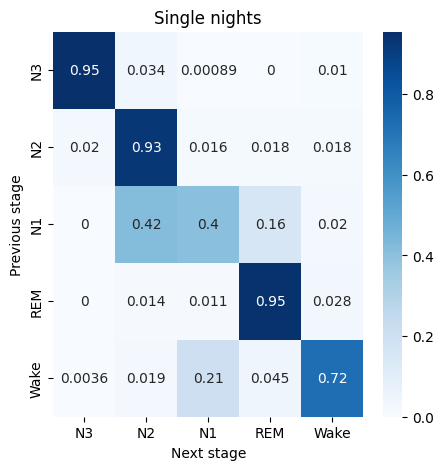

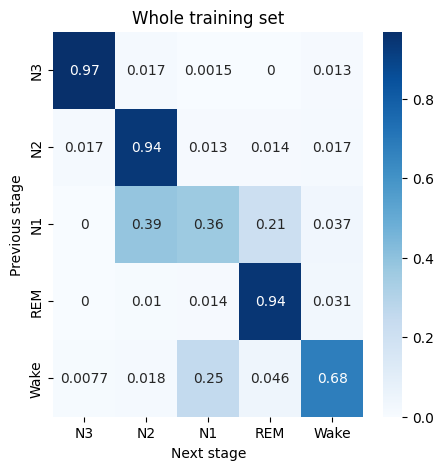

In [99]:
# Estimating the transition matrix:
def estimate_transition_matrix(y_train, training_records, hypnograms, method='single'):
    """
    Estimates the transition matrix from the training sleep stages.
    
    method:
        - single: takes the average of the estimated transition matrices night/night
        - averaged: same thing but performed once on the whole dataset
            less precise, might introduce border effect due to the roll over of the consecutive nights
    """
    if method == 'single':
        trained_tm = np.zeros((5, 5))
        i = 0
        for record in training_records:
            range_ = len(hypnograms[record])
            y_train_record = y_train[i:i+range_]
            i += range_
            y_train_record_mapped = np.array([sleep_stages_order[stage][1] for stage in y_train_record])
            trained_tm += transition_matrix(y_train_record_mapped)
        trained_tm = trained_tm / len(training_records)

    elif method == 'averaged':
        y_train_mapped = np.array([sleep_stages_order[stage][1] for stage in y_train])
        trained_tm = transition_matrix(y_train_mapped)
    else:
        raise ValueError
    return trained_tm

tm_single = estimate_transition_matrix(y_train, training_records, hypnograms, method='single')
tm_averaged = estimate_transition_matrix(y_train, training_records, hypnograms, method='averaged')

plot_transition_matrix(tm_single, 'Single nights')
plot_transition_matrix(tm_averaged, 'Whole training set')

We can directly see that some things are never happening in real life !!! For example:
- REM to N3
- N1 to N3
- N3 to REM

We can therefore safely "humanly" help the predictor and filter out these wrong predictions

In [100]:
def correct_transition_matrix(y, trained_tm, THRESHOLD=0.00001, replacement=True):
    """
    Manually correct the predictor
    
    - Improvements?:
        - If replacement needed, check for model 2nd choice (cf. predict_proba method) and so on... until we find a legitimate choice    
    """
    # WARNING: y_pred and trained_tm must have the same row correspondence (same permuation)
    y_pred = y.copy()
    y_smoothed = [y_pred[0]]
    for i, stage in enumerate(y_pred):
        if i>0:
            previous = int(y_pred[i-1])
            current = int(y_pred[i])
            proba = trained_tm[previous, current]
            if proba < THRESHOLD: # REJECT THE CURRENT STAGE : trust the previous stage
                smoothed = previous
                # IMPROVEMENT LOOK AT A WINDOW OF 2 OR 3 EPOCHS TO DECIDE (and model it using gaussian kernel / exponential decay / random forest / ...)
            else: # KEEP THE CURRENT STAGE
                smoothed = current
    
            y_smoothed.append(smoothed)
                
            if replacement:
                y_pred[i] = smoothed

    return np.array(y_smoothed)


In [101]:
def smooth_output(y_pred_mapped, window_size=10):
    """
    Low-pass filter that use discrete convolution to stabilize the predictions
    
    - Improvements?:
        - Use the transition matrix to remove outlier data by computing "variable size" rolling windows that depend in which state you currently are. This would allow finer grained precision on "more volatile" states like N1 or REM.
            - Use Markov inequality to derive a 2-sigma confidence interval on state transition duration -> can a RF or neural network learn that ? A simple decision tree or SVM/Gaussian mixture will do?
    
    WARNING: input must be mapped to the desired new order.
    """
    # Pad the data at both ends
    pad_width = window_size // 2
    y_pred_mapped_padded = np.pad(y_pred_mapped, pad_width, mode='constant', constant_values=4)

    # Apply convolution
    y_convoluted = np.round(np.convolve(y_pred_mapped_padded, np.ones(window_size) / window_size, mode='same'))

    # Clip to [0, 4]
    y_convoluted = np.clip(y_convoluted, 0, 4)

    # Extract the result without the padded values
    result = y_convoluted[pad_width:-pad_width]
    return result

In [102]:
if submit is False:
    tms = {}
    for model_name in preds.keys():
        i=0
        for record in test_records:
            plt.figure(figsize=(35, 6))

            range_ = len(hypnograms[record])
            y_true = y_test[i:i+range_]
            y_pred = preds[model_name][i:i+range_]
            i += range_
            # Map values to the desired permutation
            y_true_mapped = np.array([sleep_stages_order[stage][1] for stage in y_true])
            y_pred_mapped = np.array([sleep_stages_order[stage][1] for stage in y_pred])

            tms[record] = transition_matrix(y_true_mapped)

            # correct the transition matrix of the predicted values
            y_smoothed_mapped = correct_transition_matrix(y_pred_mapped, tm_single, THRESHOLD=0.00001)

            # 
            window_size = 2
            y_convoluted = smooth_output(y_pred_mapped, window_size)

            # Identify correct classifications
            correct_classifications = y_true_mapped == y_pred_mapped


            # Identify misclassifications
            misclassifications = y_true_mapped != y_pred_mapped

            pred_score = np.round(f1_score(y_true_mapped, y_pred_mapped, average ='macro'), 3)
            smoothed_score = np.round(f1_score(y_true_mapped, y_smoothed_mapped, average ='macro'), 3)
            convolution_score = np.round(f1_score(y_true_mapped, y_convoluted, average ='macro'), 3)

            # Plot true sleep stages
            plt.plot(y_true_mapped, 'go-', label='True')

            # Plot misclassifications in red
            plt.plot(np.where(misclassifications, y_pred_mapped, np.nan), 'go-', label='Misclassified', color='red')


            # plot the smoothed predictions in yellow
            plt.plot(y_smoothed_mapped, '-', label='Smoothed', color='yellow')
            plt.plot(y_convoluted, '-', label = 'Convolution', color = 'brown')

            # Plot correct classifications in blue crosses
            plt.plot(np.where(correct_classifications, y_true_mapped, np.nan), 'bx', label='Correctly Classified', markersize=8)


            # Set y-axis ticks and labels
            plt.yticks(range(len(new_order)), labels=new_order, fontsize=12)
            plt.xticks([])


            # Set plot properties
            plt.grid(axis='y')
            plt.title(f"{model_name} - {record} - F1 ({pred_score}) -F1 smoothed ({smoothed_score}) - F1 convolution ({convolution_score})")
            plt.legend()
            plt.show()

In [103]:
if submit is False:
    tms = {}
    score = pd.DataFrame(columns = ['window_size', 'model', 'record', 'f1', 'f1_convolution', 'f1_smooth_convolution', 'f1_convolution_smooth'])

    for window_size in range(2, 20):
        for model_name in preds.keys():
            i=0
            for record in test_records:

                range_ = len(hypnograms[record])
                y_true = y_test[i:i+range_]
                y_pred = preds[model_name][i:i+range_]
                i += range_
                # Map values to the desired permutation
                y_true_mapped = np.array([sleep_stages_order[stage][1] for stage in y_true])
                y_pred_mapped = np.array([sleep_stages_order[stage][1] for stage in y_pred])

                tms[record] = transition_matrix(y_true_mapped)

                # correct the transition matrix of the predicted values
                y_smoothed_mapped = correct_transition_matrix(y_pred_mapped, tm_single, THRESHOLD=0.0001)

                y_convoluted = smooth_output(y_pred_mapped, window_size)
                
                y_smoothed_convoluted = smooth_output(y_smoothed_mapped, window_size)    
                y_convolution_smoothed = correct_transition_matrix(y_convoluted, tm_single, THRESHOLD=0.0001)

                # Identify correct classifications
                correct_classifications = y_true_mapped == y_pred_mapped
                # Identify misclassifications
                misclassifications = y_true_mapped != y_pred_mapped

                pred_score = np.round(f1_score(y_true_mapped, y_pred_mapped, average ='macro'), 3)
                smoothed_score = np.round(f1_score(y_true_mapped, y_smoothed_mapped, average ='macro'), 3)
                convolution_score = np.round(f1_score(y_true_mapped, y_convoluted, average ='macro'), 3)
                smoothed_convolution_score = np.round(f1_score(y_true_mapped, y_smoothed_convoluted, average ='macro'), 3)
                convolution_smoothed_score = np.round(f1_score(y_true_mapped, y_convolution_smoothed, average ='macro'), 3)

                score.loc[len(score)] = [window_size, model_name, record, pred_score, convolution_score, smoothed_convolution_score, convolution_smoothed_score]

In [104]:
if submit is False:
    score.drop(columns=['model', 'record']).set_index("window_size").groupby('window_size').mean().plot(figsize=(20,5), grid=True)
    score['diff'] = score['f1_convolution'] - score['f1']

In [105]:
if submit is False:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='window_size', y='f1_convolution', data=score)
    plt.grid()
    plt.figure(figsize=(10,5))
    sns.boxplot(x='window_size', y='diff', data=score)
    plt.grid()

The low-pass filter is therefore optimal with a window width of two.

N.B. We thereby introduce a non progressive prediction. However, this is ok for the Kaggle challenge.

In [106]:
def decode_smooth_output(y_mapped):
    """
    Map predictor back to original labelling.
    """
    # Define the original order of sleep stages
#     sleep_stages_order = [('Wake', 4), ('N1', 2), ('N2', 1), ('N3', 0), ('REM', 3)]
    original_sleep_stage_order = [('N3', 3), ('N2', 2), ('N1', 1), ('REM', 4), ('Wake', 0)]
    return np.array([original_sleep_stage_order[int(stage)][1] for stage in y_mapped])

In [107]:
def post_process(y_pred):
    """
    Apply Low Band filtering using Convolution and Padding to smooth the predictor.
    """
    # Permutation
    y_pred = np.array([sleep_stages_order[stage][1] for stage in y_pred])
    # Convolution
    y_pred = smooth_output(y_pred, window_size=2)
    # Permutation (Back)
    return decode_smooth_output(y_pred)

### F1 Cross Validation of the Post-Processing stage:

In [108]:
# if submit:
#     skf = StratifiedKFold(n_splits=5, shuffle=False)
#     f1_scores = {model_name: [] for model_name in list_model_names}
#     f1_scores_smoothed = {model_name: [] for model_name in list_model_names}

#     for model, model_name in zip(list_models, list_model_names):
#         for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
#             X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#             y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
#             print(f" --- Fold {i+1} - {model_name} ---")
#             # Train
#             model.fit(X_train_fold, y_train_fold)
#             # Predict
#             predictions_val = model.predict(X_val_fold)
#             # Post Process
#             predictions_val_smoothed = post_process(predictions_val)

#             # Score
#             f1_fold = f1_score(y_val_fold, predictions_val, average='macro')
#             f1_fold_smoothed = f1_score(y_val_fold, predictions_val_smoothed, average='macro')
#             f1_scores[model_name].append(f1_fold)
#             f1_scores_smoothed[model_name].append(f1_fold_smoothed)

#             plot_confusion_matrix(y_val_fold, predictions_val, class_names=class_names, title=f'Confusion Matrix - Fold {i+1} - {model_name} F1: {f1_fold:.4f}')
#             plot_confusion_matrix(y_val_fold, predictions_val_smoothed, class_names=class_names, title=f'Confusion Matrix - Fold {i+1} - {model_name} F1 Smoothed: {f1_fold_smoothed:.4f}')

#         f1_scores[model_name] = np.mean(f1_scores[model_name])
#         f1_scores_smoothed[model_name] = np.mean(f1_scores_smoothed[model_name])

In [109]:
# f1_scores

In [110]:
# f1_scores_smoothed

### Bonus: why not just use the best model we have instead ?

In [111]:
best_pick_xgb = False
best_pick_lgbm = False

if submit and best_pick_xgb:
    xgb_model.fit(X_train, y_train)
elif submit and best_pick_lgbm:
    lgbm_model.fit(X_train, y_train)

In [112]:
apply_postprocessing = True

# Out of Sample Predictions (Kaggle Submission)

In [113]:
predictions = []
for record in os.listdir("test_records"):
    print("Record:", record)
    record_number = int(record[-5])
    x = np.load(f'test_records/{record}')

    data_for_test_records = {}

    # Extracting EEG channels
    eeg_channels = [
        x[:, 1:7501],
        x[:, 7501:15001],
        x[:, 15001:22501],
        x[:, 22501:30001],
        x[:, 30001:37501]
    ]

    # Loop through each EEG channel
    for i, eeg_data_for_record in enumerate(eeg_channels):
        channel_name = f"EEG_{i + 1}"  # EEG_1, EEG_2, EEG_3, EEG_4, ...
        eeg_data_for_record_clipped = clip_data(eeg_data_for_record, "EEG")
        data_for_test_records[channel_name] = get_relative_spectral_power_for_epoch(eeg_data_for_record_clipped,"EEG", frequency_bands)
        data_for_test_records[channel_name].update(compute_stats_torcheeg(eeg_data_for_record, statistics_eeg_torcheeg, verbose=verbose))
        data_for_test_records[channel_name].update(compute_stats(eeg_data_for_record_clipped, statistics_eeg, verbose=False))
        data_for_test_records[channel_name] = pd.DataFrame(data_for_test_records[channel_name])

    # Extracting accelerometer channels
    accelerometer_channels = [
        x[:, 37501:39001],
        x[:, 39001:40501],
        x[:, 40501:42001]
    ]

    # Loop through each accelerometer channel
    for i, acc_data_for_record in enumerate(accelerometer_channels):
        channel_name = f"Accelerometer_{i + 1}"  # Accelerometer_1, Accelerometer_2, Accelerometer_3
        acc_data_for_record_clipped = clip_data(acc_data_for_record, "Accelerometer")
        data_for_test_records[channel_name] = get_relative_spectral_power_for_epoch(acc_data_for_record_clipped,"Accelerometer", frequency_bands)
        data_for_test_records[channel_name].update(compute_stats(acc_data_for_record_clipped, statistics_acc, verbose=False))
        data_for_test_records[channel_name] = pd.DataFrame(data_for_test_records[channel_name])

    # Compute the macro features
    for macro_feature_name, macro_feature in macro_features.items():
        data = []
        if macro_feature['type'] == 'EEG':
            for channel in macro_feature['channels']:
                signal_ = clip_data(eeg_channels[channel], "EEG")
                data.append(signal_)
        else:
            for channel in macro_feature['channels']:
                signal_ = clip_data(accelerometer_channels[channel], "Accelerometer")
                data.append(signal_)

        f = macro_feature['function']
        result = f(data)
        data_for_test_records[macro_feature_name] = result
        data_for_test_records[macro_feature_name] = pd.DataFrame(data_for_test_records[macro_feature_name])

    # Kaggle submission dataset 
    X_test_record  = pd.concat(data_for_test_records.values(), axis=1).values
    
    # Optional: NaN remover
    remove_nan = False
    if remove_nan:
        X_test_record = pd.DataFrame(X_test_record, columns=variable_list)
        X_test_record = X_test_record.drop(columns=columns_to_remove_train).values

    # Optional: Cherry-picking
    if best_pick_xgb:
        preds = xgb_model.predict(X_test_record)
    elif best_pick_lgbm:
        preds = lgbm_model.predict(X_test_record)
    else:
#         preds = stacking_model.predict(X_test_record)
        preds = final_model.predict(X_test_record)

    # Optional: Post-processing
    if apply_postprocessing:
        preds = post_process(preds)

    # Append the predictions to the list of predictions (Kaggle format)
    for i, pred_class in enumerate(preds):
        predictions.append({"identifier":record_number * 10000 + i,'target':pred_class})

# Submitting to Kaggle
predictions = pd.DataFrame(predictions)
predictions.to_csv('/kaggle/working/submission.csv',index = None)

Record: dreem_9.npy
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis


/opt/conda/lib/python3.10/site-packages/torcheeg/transforms/numpy/band_pyeeg.py:416: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += np.linalg.lstsq(c, y)[1]


Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient


/tmp/ipykernel_19/3342981167.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += np.linalg.lstsq(c, y)[1]
/tmp/ipykernel_19/3342981167.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = np.linalg.lstsq(np.vstack(


Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis
Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis
Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computi

/opt/conda/lib/python3.10/site-packages/torcheeg/transforms/numpy/band_pyeeg.py:416: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += np.linalg.lstsq(c, y)[1]


Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient


/tmp/ipykernel_19/3342981167.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += np.linalg.lstsq(c, y)[1]
/tmp/ipykernel_19/3342981167.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = np.linalg.lstsq(np.vstack(


Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis
Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis
Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computi

/opt/conda/lib/python3.10/site-packages/torcheeg/transforms/numpy/band_pyeeg.py:416: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += np.linalg.lstsq(c, y)[1]


Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient


/tmp/ipykernel_19/3342981167.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += np.linalg.lstsq(c, y)[1]
/tmp/ipykernel_19/3342981167.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = np.linalg.lstsq(np.vstack(


Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis
Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computing bandmeanabsolutedeviation
Computing bandkurtosis
Computing bandskewness
Computing bandsvdentropy
Computing banddetrendedfluctuationanalysis
Computing bandpetrosianfractaldimension
Computing bandhiguchifractaldimension
Computing bandhjorthmobility
Computing bandhjorthcomplexity
Computing arcoefficient
Computing bandbinpower
Computing banddiffereentialentropy
Computing bandspectralentropy
Computing bandpowerspectraldensity
Computi

# Error analysis

In [114]:
plot_importance_xgb(xgb_model, variable_list_updated)

NotFittedError: need to call fit or load_model beforehand

In [ ]:
if submit is False:
    plot_importance_rf(rf_model, X_test, y_test, variable_list_updated)

Pour aller + loin: TODO: faire la même chose mais avec une pipeline PCAs Il faut voir comment on store dans une liste l'index des colonnes features retenues par le screening PCA pour les passer en "variable_list_pca"..... 